In [90]:
import numpy as np
import camb
from matplotlib import pyplot as plt
import time

Using Jon's piece of code to get the $\chi^2$

In [91]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

chisq is  15267.937674122833  for  2501  degrees of freedom.


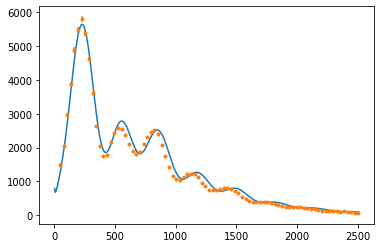

In [92]:
pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3])
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

## 1) 

In [95]:
dof = len(resid)-len(pars)
print("chi2 mean is {} +- {}".format(dof, np.sqrt(2*dof)))

chi2 mean is 2501 +- 70.7248188403477


$\chi^2$ should ideally be 2501 +- 70.72. So, the above case where $\chi^2 = 15267.94$ is not an acceptable fit.

chisq is  3272.2036740262683  for  2501  degrees of freedom.


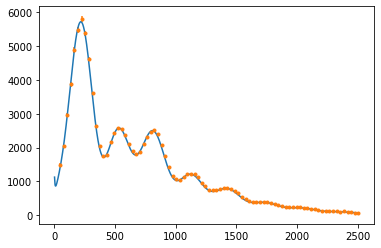

In [96]:
pars=np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
dof = len(resid)-len(pars)
print("chisq is ",chisq," for ",dof," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3])
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

$\chi^2$ should ideally be 2501 +- 70.72. So, the above case where $\chi^2 = 3272.20$ is a better fit than the previous fit but still not an acceptable fit.

## 2)

In [97]:
#Function to get the numerical derivatives. Returns the model at the current parameters and the curvature matrix
def get_derivs(fun,pars,dp,n):
    mymod=fun(pars)[:n]
    npar=len(pars)
    dplus=[None]*npar
    dminus=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pp[i]+dp[i]
        dplus[i]=fun(pp)[:n]
        pp=pars.copy()
        pp[i]=pp[i]-dp[i]
        dminus[i]=fun(pp)[:n]
    A=np.empty([n,npar])
    #actually do the numerical derivatives
    for i in range(npar):
        A[:,i]=(dplus[i]-dminus[i])/(2*dp[i])
        
    return mymod,A

#Fucntion to do the newton method
def newton(pars,fun,data,errs,dp,chisq,niter=10):
    len_data = len(data)
    curv = np.zeros([len(data), len(pars)])
    f = open('planck_fit_params.txt', 'w')
    for i in range(niter):
        mod,A=get_derivs(fun,pars,dp,len_data)
        n = len(errs)
        N_inv = np.zeros([n,n])
        #the noise matrix is a diagonal matrix with each element in the diagonal obtained from the error in the 
        #data points
        for j in range(n):
            N_inv[j][j] = 1/errs[j]**2 
        r=data-mod
        #Convergence criteria is that the new chisq from the current step and the chisq in the previous step 
        #should differ by less than 10^-5
        chisq_new = np.sum((r/errs)**2)
        delta_chisq = np.abs(chisq - chisq_new)
        if delta_chisq < pow(10,-5):
            print("chi sqaure is less that 10^-5, convergence reached!")
            curv = A.copy()
            break
        #Getting the new parameters and their errors and writing them to the file
        lhs=A.T@N_inv@A
        rhs=A.T@N_inv@r
        dp=np.linalg.inv(lhs)@rhs
        pars=pars+dp
        par_errs = np.diag(np.sqrt(np.linalg.inv(lhs)))
        chisq = chisq_new
        f.write('on interation '+ str(i) + ' parameters are ' +str(pars)+' and their errors are '+str(par_errs))
        f.write('\n')
        print('on interation ',i,' parameters are ',pars,' and their errors are ',str(par_errs))
    f.close()
    #Returning the best-fit parameters and the corresponding curvature matrix
    return pars, curv

In [98]:
#Calling newton with the initial parameters I used in part 1
pars=np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
dp=np.asarray([0.1, 0.0001, 0.001, 0.001, 1e-10, 0.001])
#giving the initial chisq as 10000
pars_fit, curv = newton(pars, get_spectrum, spec, errs, dp, 10000)

/home/vishwangi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


on interation  0  parameters are  [6.84151608e+01 2.23790078e-02 1.17196116e-01 1.10895115e-01
 2.32020577e-09 9.74739241e-01]  and their errors are  [1.20403712e+00 2.28843600e-04 2.72349944e-03 3.65643551e-02
 1.46100471e-10 6.45504612e-03]
on interation  1  parameters are  [6.80942760e+01 2.23459280e-02 1.17993779e-01 7.95385472e-02
 2.19164783e-09 9.72156977e-01]  and their errors are  [1.19881450e+00 2.29439547e-04 2.67424397e-03 3.20233425e-02
 1.39884353e-10 6.75250632e-03]
on interation  2  parameters are  [6.82706471e+01 2.23676319e-02 1.17604405e-01 8.67848068e-02
 2.22474837e-09 9.73194082e-01]  and their errors are  [1.18790089e+00 2.29742041e-04 2.66398363e-03 3.47044095e-02
 1.44305128e-10 6.54852439e-03]
on interation  3  parameters are  [6.82229367e+01 2.23608930e-02 1.17709308e-01 8.45085642e-02
 2.21545257e-09 9.72948436e-01]  and their errors are  [1.18490509e+00 2.29117632e-04 2.64678077e-03 3.39359188e-02
 1.42883098e-10 6.57546382e-03]
on interation  4  parameters

## 3)

In [104]:
#Getting the covariance matrix of the parameters from the curvature matrix of the best-fit paramters obtained in 
#part 2
n= len(errs)
N_inv = np.zeros([n,n])
for j in range(n):
    N_inv[j][j] = 1/errs[j]**2
cov = np.linalg.inv(curv.T@N_inv@curv)

In [100]:
cov

array([[ 1.41207418e+00,  1.93074882e-04, -3.08080514e-03,
         2.26021312e-02,  8.37046505e-11,  6.93497930e-03],
       [ 1.93074882e-04,  5.26616678e-08, -3.54483442e-07,
         3.00762646e-06,  1.15815741e-14,  7.50196573e-07],
       [-3.08080514e-03, -3.54483442e-07,  7.05719087e-06,
        -4.96404737e-05, -1.81509472e-13, -1.56780931e-05],
       [ 2.26021312e-02,  3.00762646e-06, -4.96404737e-05,
         1.16541799e-03,  4.87415800e-12,  1.25000151e-04],
       [ 8.37046505e-11,  1.15815741e-14, -1.81509472e-13,
         4.87415800e-12,  2.05428657e-20,  4.60460998e-13],
       [ 6.93497930e-03,  7.50196573e-07, -1.56780931e-05,
         1.25000151e-04,  4.60460998e-13,  4.33505953e-05]])

In [10]:
#Get the chi2 for each step
def get_chi2(p, data, errs):
    pred=get_spectrum(p)[:len(data)]
    chisq=np.sum(((pred-data)/errs)**2)
    return chisq

In [102]:
#Get dp from the multivariate normal distribution of the parameters
def get_step(p, cov):
    mean = np.zeros([len(p)])
    dp = np.random.multivariate_normal(mean, cov)*0.3 #the 0.3 factor to ensure a small step size
    return dp

In [103]:
#Function which does the mcmc
def run_chain(fun,pars,cov,data,errs,nstep=8000,T=1):
    f = open('planck_chain.txt', 'w')
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chisq=np.zeros(nstep)
    chain[0,:]=pars
    chi_cur=fun(pars,data,errs)
    chisq[0]=chi_cur
    f.write(str(0)+','+str(chisq[0])+','+str(chain[0]))
    f.write('\n')
    for i in range(1,nstep):
        pp=pars+get_step(pars, cov)
        new_chisq=fun(pp,data,errs)
        #We want the chisq to go down. So, new parameters will be accepted with more probability if the new chisq
        #is less than the old one
        accept_prob=np.exp(-0.5*(new_chisq-chi_cur)/T)
        if np.random.rand(1)<accept_prob:
            pars=pp
            chi_cur=new_chisq
        chain[i,:]=pars
        chisq[i]=chi_cur
        #For each step, the file has a row with the step number, chi squared value and the parameters value
        f.write(str(i)+','+str(chisq[i])+','+str(chain[i]))
        f.write('\n')
    return chain,chisq

In [105]:
#Function to get the mean and std of the parameters from the chain
def process_chain(chain,chisq,T=1.0):
    #Since we want to minimise chi squared, the parameters which are closer to the minimum chi squared value are 
    #given more weight and those farther from the minimum chi squared value are given less weight
    dchi=chisq-np.min(chisq)
    wt=np.exp(-0.5*dchi*(1-1/T))
    npar=chain.shape[1]
    tot=np.zeros(npar)
    totsqr=np.zeros(npar)
    for i in range(npar):
        tot[i]=np.sum(wt*chain[:,i])
        totsqr[i]=np.sum(wt*chain[:,i]**2)
    #divide by sum or weights
    mean=tot/np.sum(wt)
    meansqr=totsqr/np.sum(wt)
    #variance is <x^2>-<x>^2
    var=meansqr-mean**2
    return mean,np.sqrt(var),wt

In [24]:
#Run the mcmc
chain,chivec=run_chain(get_chi2,pars_fit,cov,spec,errs)

In [68]:
#I am saving the chain and the chisq in these files so that I can access them easily for further analysis, but
#these values are also saved in planck_chain.txt
np.savetxt("chain.txt", chain, delimiter=',')
np.savetxt("chisq.txt", chisq, delimiter=',')

In [106]:
#Read in the chain and chisq from the files
chain_file = open("chain.txt", "r")
chisq_file = open("chisq.txt", "r")
chain = np.zeros([8000, len(pars_fit)])
chisq = np.zeros([8000])
i = 0
for line in chain_file:
    line = line.split(',')
    for j in range(len(pars_fit)):
        chain[i][j] = float(line[j])
    i +=1
i = 0
for line in chisq_file:
    chisq[i] = float(line)
    i +=1

In [107]:
#Mean and std of the parameters
mean, std, wt = process_chain(chain, chisq)
print("Parameters from the mcmc are:")
print("H0 = {} +- {}".format(mean[0], std[0]))
print("omega_baryon = {} +- {}".format(mean[1], std[1]))
print("omega_darkmatter = {} +- {}".format(mean[2], std[2]))
print("tau = {} +- {}".format(mean[3], std[3]))
print("amp = {} +- {}".format(mean[4], std[4]))
print("tilt = {} +- {}".format(mean[5], std[5]))

Parameters from the mcmc are:
H0 = 68.1312566130956 +- 1.106005902998262
omega_baryon = 0.022353228548148137 +- 0.0002445206454031574
omega_darkmatter = 0.11789544266652258 +- 0.002428244830861377
tau = 0.08660835042120955 +- 0.026436818179836463
amp = 2.2284908486160026e-09 +- 1.1118958517380318e-10
tilt = 0.9724305743124553 +- 0.0060566625449622255


In [108]:
H0_normalised = (chain[:,0] - mean[0])/std[0]
omegab_normalised = (chain[:,1] - mean[1])/std[1]
omegadm_normalised = (chain[:,2] - mean[2])/std[2]
tau_normalised = (chain[:,3] - mean[3])/std[3]
amp_normalised = (chain[:,4] - mean[4])/std[4]
tilt_normalised = (chain[:,5] - mean[5])/std[5]

Text(0, 0.5, 'parameters')

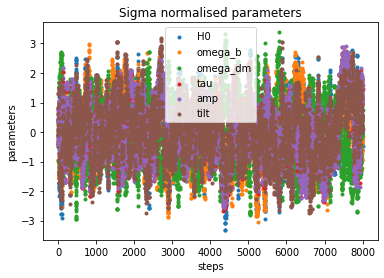

In [109]:
steps = np.arange(8000)
plt.scatter(steps, H0_normalised, label = "H0", marker = '.')
plt.scatter(steps, omegab_normalised, label = "omega_b", marker = '.')
plt.scatter(steps, omegadm_normalised, label = "omega_dm", marker = '.')
plt.scatter(steps, tau_normalised, label = "tau", marker = '.')
plt.scatter(steps, amp_normalised, label = "amp", marker = '.')
plt.scatter(steps, tilt_normalised, label = "tilt", marker = '.')
plt.legend()
plt.title("Sigma normalised parameters")
plt.xlabel("steps")
plt.ylabel("parameters")

Text(0.5, 1.0, 'Power density spectrum of the parameters')

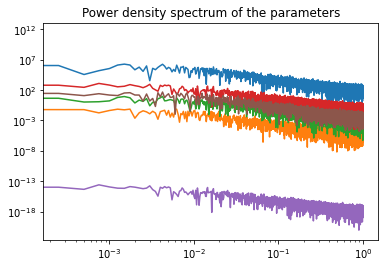

In [110]:
for i in range(6):
    psd = np.abs(np.fft.rfft(chain[:,i]))**2
    plt.loglog(np.linspace(0,1,len(psd)),psd)
plt.title("Power density spectrum of the parameters")

Fourier transform of the parameters shows a flat power spectral density along the x-axis, indicating that the samples are like white noise and thus convergence is reached! 

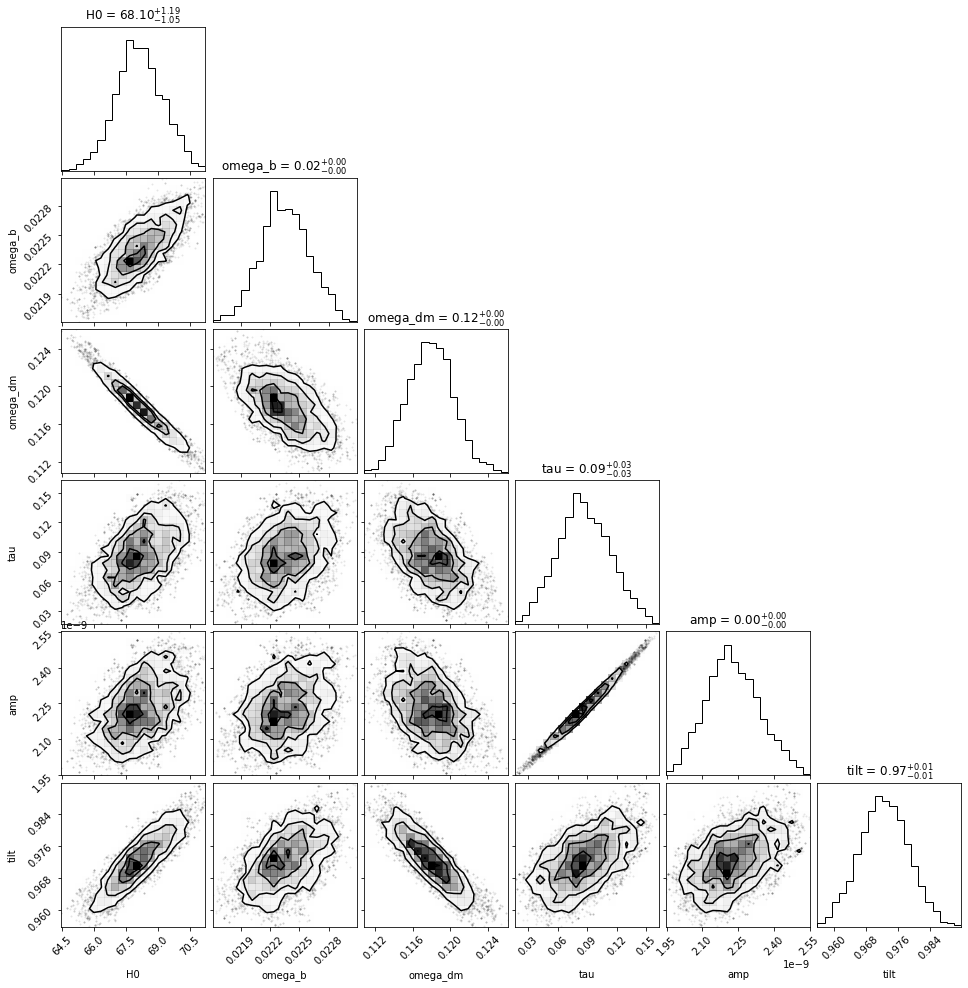

In [111]:
from corner import corner
corner(chain,labels=['H0', 'omega_b', 'omega_dm', 'tau', 'amp', 'tilt'],show_titles=True);

Corner plot shows a gaussian distribution for each parameter!

We have: <br>
$H_0 = 68.1312566130956 +/- 1.106005902998262$ <br>
$h = H_0/100 = 0.681312566130956 +/- 0.011060059029982621$ <br>
$\Omega_bh^2 = 0.022353228548148137 +/- 0.0002445206454031574$ <br>
$\Omega_{c}h^2 = 0.11789544266652258 +/- 0.002428244830861377$ <br>
Using the above equations and uncertainty propagation formulas: <br>
$\delta h^2 = 0.08363986419645297$ <br>
$\Omega_b = 0.048155673391184296 +/- 0.02105260758698921$ <br>
$\Omega_{c} = 0.2539827488064804 +/- 0.11380648682825965$ <br>
Using $\Omega_b + \Omega_{c} + \Omega_\Lambda = 1$: <br>
$\Omega_\Lambda = 0.6978615778023353 +/- 0.11573732643534926$

## 4)

To run a new mcmc chain with the constraint on tau, I write an new fucntion to get the $\chi^2$. This fucntion has 
a $\delta \chi^2$ added to the original $\chi^2$, where the $\delta \chi^2$ is high if the tau parameter value is farther from the given constraint. Thus, the step which has the tau parameter value closer to the given constraint has lesser $\chi^2$ and more probability of acceptance

In [112]:
def get_chi2_new(p, data, errs, prior, prior_sigma):
    pred=get_spectrum(p)[:len(data)]
    chisq=np.sum(((pred-data)/errs)**2)
    delta_chisq = ((prior - p[3])/prior_sigma)**2
    chisq += delta_chisq
    return chisq

In [113]:
#The tau prior
prior = 0.0540
prior_sigma = 0.0074

For the new chain, I get a new covariance matrix of parameters from which the dp would be drawn. The new 
covaraince matrix is calculated from the chain I obtained in part 3. Each step in the chain will now have a weight 
when the covariance is calculated. The weight is higher if the tau parameter in the step is closer to the prior 
value

In [114]:
weights = np.zeros([len(chain)])
for i in range(len(chain)):
    dchi2 = ((prior - chain[i][3])/prior_sigma)**2
    weights[i] = np.exp(-0.5*dchi2)
cov_new = np.cov(chain, rowvar = 0, aweights=weights)

In [115]:
def run_chain_new(fun,pars,cov,data,errs,prior, prior_sigma,nstep=8000,T=1):
    f = open('planck_chain_tauprior.txt', 'w')
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chisq=np.zeros(nstep)
    chain[0,:]=pars
    chi_cur=fun(pars,data,errs,prior, prior_sigma)
    chisq[0]=chi_cur
    #For each step, the step number, chisq and parameter values are saved in planck_chain_tauprior.txt
    f.write(str(0)+','+str(chisq[0])+','+str(chain[0]))
    f.write('\n')
    for i in range(1,nstep):
        pp=pars+get_step(pars, cov)
        new_chisq=fun(pp,data,errs,prior, prior_sigma)
        accept_prob=np.exp(-0.5*(new_chisq-chi_cur)/T)
        if np.random.rand(1)<accept_prob:
            pars=pp
            chi_cur=new_chisq
        chain[i,:]=pars
        chisq[i]=chi_cur
        f.write(str(i)+','+str(chisq[i])+','+str(chain[i]))
        print(str(i)+','+str(chisq[i])+','+str(chain[i]))
        f.write('\n')
    f.close()
    return chain,chisq

In [68]:
#Running the new chain with the prior
chain_tauprior,chivec_tau_prior=run_chain_new(get_chi2_new,pars_fit,cov_new,spec,errs,prior,prior_sigma)

1,2591.335626577595,[6.79335459e+01 2.23264195e-02 1.18575501e-01 8.23232371e-02
 2.20984341e-09 9.72644443e-01]
2,2591.335626577595,[6.79335459e+01 2.23264195e-02 1.18575501e-01 8.23232371e-02
 2.20984341e-09 9.72644443e-01]
3,2591.335626577595,[6.79335459e+01 2.23264195e-02 1.18575501e-01 8.23232371e-02
 2.20984341e-09 9.72644443e-01]
4,2591.335626577595,[6.79335459e+01 2.23264195e-02 1.18575501e-01 8.23232371e-02
 2.20984341e-09 9.72644443e-01]
5,2595.974870757656,[6.78747668e+01 2.22793324e-02 1.18791518e-01 8.50509245e-02
 2.22005255e-09 9.74051146e-01]
6,2592.479663786836,[6.81663575e+01 2.23682138e-02 1.18257822e-01 8.24804550e-02
 2.20770377e-09 9.74567038e-01]
7,2590.2645730329523,[6.83938511e+01 2.23948400e-02 1.17904404e-01 7.98408272e-02
 2.19700326e-09 9.74248299e-01]
8,2588.8487054406537,[6.77530435e+01 2.22725380e-02 1.19283697e-01 7.76668551e-02
 2.19648717e-09 9.69981266e-01]
9,2588.8487054406537,[6.77530435e+01 2.22725380e-02 1.19283697e-01 7.76668551e-02
 2.19648717e

73,2585.2128055007706,[6.86240884e+01 2.21548888e-02 1.16818636e-01 5.31525914e-02
 2.08076833e-09 9.76949652e-01]
74,2585.2128055007706,[6.86240884e+01 2.21548888e-02 1.16818636e-01 5.31525914e-02
 2.08076833e-09 9.76949652e-01]
75,2585.2128055007706,[6.86240884e+01 2.21548888e-02 1.16818636e-01 5.31525914e-02
 2.08076833e-09 9.76949652e-01]
76,2584.1350348387195,[6.86481422e+01 2.21902775e-02 1.16836896e-01 5.90205963e-02
 2.10435076e-09 9.77393663e-01]
77,2582.955435696141,[6.87648462e+01 2.21912146e-02 1.16271856e-01 5.80175433e-02
 2.09821816e-09 9.76811464e-01]
78,2582.955435696141,[6.87648462e+01 2.21912146e-02 1.16271856e-01 5.80175433e-02
 2.09821816e-09 9.76811464e-01]
79,2582.9950060334104,[6.80277852e+01 2.20783592e-02 1.17994418e-01 5.80766032e-02
 2.10753775e-09 9.72974054e-01]
80,2582.388508029599,[6.79563420e+01 2.20597392e-02 1.18044243e-01 5.55483153e-02
 2.09573980e-09 9.73719999e-01]
81,2582.388508029599,[6.79563420e+01 2.20597392e-02 1.18044243e-01 5.55483153e-02
 

145,2579.985207935209,[6.85290055e+01 2.22061178e-02 1.16774980e-01 5.58696460e-02
 2.08763254e-09 9.74160186e-01]
146,2580.1391677280476,[6.85687753e+01 2.22527908e-02 1.16819127e-01 5.79964391e-02
 2.10017243e-09 9.72561415e-01]
147,2580.1391677280476,[6.85687753e+01 2.22527908e-02 1.16819127e-01 5.79964391e-02
 2.10017243e-09 9.72561415e-01]
148,2580.1391677280476,[6.85687753e+01 2.22527908e-02 1.16819127e-01 5.79964391e-02
 2.10017243e-09 9.72561415e-01]
149,2584.817292623287,[6.90655969e+01 2.22873027e-02 1.15678117e-01 5.83499171e-02
 2.09828162e-09 9.72248025e-01]
150,2582.49206687099,[6.91658121e+01 2.24156651e-02 1.15658527e-01 5.37370993e-02
 2.07763685e-09 9.72930443e-01]
151,2583.116951108918,[6.93895514e+01 2.24604408e-02 1.15156839e-01 4.98531303e-02
 2.05902292e-09 9.74366078e-01]
152,2583.116951108918,[6.93895514e+01 2.24604408e-02 1.15156839e-01 4.98531303e-02
 2.05902292e-09 9.74366078e-01]
153,2583.0203618166042,[6.98104068e+01 2.25384492e-02 1.14308660e-01 5.1033042

216,2580.3593919489135,[6.80202356e+01 2.23395530e-02 1.18487646e-01 5.93795059e-02
 2.11702159e-09 9.67372294e-01]
217,2581.320458058927,[6.83504170e+01 2.24693353e-02 1.18076092e-01 6.02452362e-02
 2.11959488e-09 9.68466156e-01]
218,2581.565924285914,[6.83037617e+01 2.24871167e-02 1.18139545e-01 5.79446419e-02
 2.11070136e-09 9.67353081e-01]
219,2585.061895706273,[6.85489757e+01 2.26611541e-02 1.18200811e-01 6.02760368e-02
 2.12185048e-09 9.67616004e-01]
220,2586.382730763212,[6.83493719e+01 2.27204236e-02 1.18950834e-01 5.95442027e-02
 2.12106858e-09 9.66870926e-01]
221,2584.8963048575333,[6.80059339e+01 2.26050583e-02 1.19358933e-01 6.06718847e-02
 2.12645520e-09 9.65022395e-01]
222,2584.8963048575333,[6.80059339e+01 2.26050583e-02 1.19358933e-01 6.06718847e-02
 2.12645520e-09 9.65022395e-01]
223,2585.143980087443,[6.87089056e+01 2.26950247e-02 1.17673281e-01 5.52253868e-02
 2.09577583e-09 9.67811514e-01]
224,2585.143980087443,[6.87089056e+01 2.26950247e-02 1.17673281e-01 5.5225386

287,2587.552546578316,[6.66585728e+01 2.21153156e-02 1.20045763e-01 4.64451244e-02
 2.06447661e-09 9.62460754e-01]
288,2587.552546578316,[6.66585728e+01 2.21153156e-02 1.20045763e-01 4.64451244e-02
 2.06447661e-09 9.62460754e-01]
289,2588.514575483857,[6.60236908e+01 2.19970627e-02 1.21427233e-01 4.72608791e-02
 2.07402871e-09 9.59981589e-01]
290,2588.5687411445347,[6.62687883e+01 2.20339657e-02 1.20920469e-01 4.64657819e-02
 2.06842925e-09 9.60332261e-01]
291,2588.5687411445347,[6.62687883e+01 2.20339657e-02 1.20920469e-01 4.64657819e-02
 2.06842925e-09 9.60332261e-01]
292,2589.238561703587,[6.58256003e+01 2.19643273e-02 1.21928702e-01 4.72060530e-02
 2.07774251e-09 9.58180685e-01]
293,2588.198182268308,[6.60034419e+01 2.19825198e-02 1.21580501e-01 4.54058144e-02
 2.06969799e-09 9.59178641e-01]
294,2588.198182268308,[6.60034419e+01 2.19825198e-02 1.21580501e-01 4.54058144e-02
 2.06969799e-09 9.59178641e-01]
295,2587.666356148872,[6.61849600e+01 2.19839657e-02 1.21072025e-01 4.47462730

358,2586.798678054468,[6.70003913e+01 2.18500655e-02 1.19178174e-01 4.41067374e-02
 2.05349564e-09 9.68002908e-01]
359,2586.7189241252495,[6.70706384e+01 2.18903716e-02 1.19088008e-01 4.26588276e-02
 2.04712375e-09 9.68534384e-01]
360,2589.627505893042,[6.62558767e+01 2.17644401e-02 1.20840063e-01 4.16423069e-02
 2.05187306e-09 9.64477255e-01]
361,2590.8493600837633,[6.66811002e+01 2.18303758e-02 1.19847046e-01 3.74997494e-02
 2.03013185e-09 9.65401607e-01]
362,2590.8493600837633,[6.66811002e+01 2.18303758e-02 1.19847046e-01 3.74997494e-02
 2.03013185e-09 9.65401607e-01]
363,2590.8493600837633,[6.66811002e+01 2.18303758e-02 1.19847046e-01 3.74997494e-02
 2.03013185e-09 9.65401607e-01]
364,2591.2266509881338,[6.62939836e+01 2.17398386e-02 1.20731694e-01 3.80044524e-02
 2.03520246e-09 9.65296460e-01]
365,2586.881361843671,[6.61830698e+01 2.17913612e-02 1.21308114e-01 4.22195397e-02
 2.05547151e-09 9.64396753e-01]
366,2586.881361843671,[6.61830698e+01 2.17913612e-02 1.21308114e-01 4.22195

429,2578.079461605827,[6.76469633e+01 2.22508905e-02 1.18679735e-01 5.50944054e-02
 2.09690087e-09 9.68407080e-01]
430,2579.718779034957,[6.79056060e+01 2.22502346e-02 1.17988712e-01 5.87252003e-02
 2.11047817e-09 9.69966510e-01]
431,2579.6721484937493,[6.82918453e+01 2.23647579e-02 1.17555286e-01 5.88983613e-02
 2.10997366e-09 9.71785359e-01]
432,2579.6721484937493,[6.82918453e+01 2.23647579e-02 1.17555286e-01 5.88983613e-02
 2.10997366e-09 9.71785359e-01]
433,2578.633186046334,[6.85675755e+01 2.24674677e-02 1.17215555e-01 5.77773704e-02
 2.10218435e-09 9.72155015e-01]
434,2578.652144866728,[6.84213676e+01 2.23842278e-02 1.17440544e-01 5.58762037e-02
 2.09570831e-09 9.72196113e-01]
435,2577.7552977099267,[6.79617412e+01 2.22737389e-02 1.18244104e-01 5.81316704e-02
 2.10722262e-09 9.70843503e-01]
436,2578.3274881353436,[6.83019725e+01 2.23848991e-02 1.17495913e-01 5.99512474e-02
 2.11186732e-09 9.71410507e-01]
437,2579.677390203623,[6.83194336e+01 2.23069872e-02 1.17295149e-01 6.363464

500,2587.6848458594745,[6.90550241e+01 2.24157143e-02 1.16173627e-01 5.75983309e-02
 2.09265181e-09 9.71673189e-01]
501,2587.3198901345568,[6.89641809e+01 2.23256666e-02 1.16038240e-01 6.02619582e-02
 2.10251095e-09 9.71934885e-01]
502,2586.830287377109,[6.88737491e+01 2.22200775e-02 1.15875796e-01 6.44224143e-02
 2.11917569e-09 9.72765684e-01]
503,2585.994939841728,[6.87105430e+01 2.22807245e-02 1.16685540e-01 6.51709232e-02
 2.12772728e-09 9.71400076e-01]
504,2583.8256748712706,[6.86142264e+01 2.23382797e-02 1.17215097e-01 6.19878087e-02
 2.11720763e-09 9.71223925e-01]
505,2582.6598510467447,[6.84460311e+01 2.23645055e-02 1.17758595e-01 6.10097796e-02
 2.11412155e-09 9.71704765e-01]
506,2582.288084038535,[6.83248848e+01 2.23287047e-02 1.17755523e-01 5.88405312e-02
 2.10367125e-09 9.70987574e-01]
507,2582.288084038535,[6.83248848e+01 2.23287047e-02 1.17755523e-01 5.88405312e-02
 2.10367125e-09 9.70987574e-01]
508,2581.788262970207,[6.85180082e+01 2.23569728e-02 1.17445067e-01 5.926257

572,2584.185457045263,[6.68539591e+01 2.18864797e-02 1.20151817e-01 4.80655725e-02
 2.07157782e-09 9.71028920e-01]
573,2583.9180843954027,[6.67333297e+01 2.18581021e-02 1.20358115e-01 4.94130647e-02
 2.07697551e-09 9.70815755e-01]
574,2582.1684256591834,[6.70303214e+01 2.19328256e-02 1.19842123e-01 4.78744337e-02
 2.06962427e-09 9.70366816e-01]
575,2582.167795613371,[6.67984016e+01 2.19729291e-02 1.20594386e-01 4.92306381e-02
 2.08139560e-09 9.68407556e-01]
576,2581.732802317139,[6.69654072e+01 2.20271768e-02 1.20323742e-01 4.74852751e-02
 2.07319184e-09 9.68617165e-01]
577,2582.197476829438,[6.69192378e+01 2.19973092e-02 1.20285869e-01 4.55330768e-02
 2.06371775e-09 9.68981856e-01]
578,2581.7879073067174,[6.64350720e+01 2.20524811e-02 1.21509157e-01 4.53486539e-02
 2.06858158e-09 9.66076234e-01]
579,2581.7879073067174,[6.64350720e+01 2.20524811e-02 1.21509157e-01 4.53486539e-02
 2.06858158e-09 9.66076234e-01]
580,2581.0964631192423,[6.67270816e+01 2.21480092e-02 1.20855717e-01 5.03681

643,2582.57450513931,[6.74354284e+01 2.21378932e-02 1.18481973e-01 4.62578734e-02
 2.05710458e-09 9.67598584e-01]
644,2584.2381442441533,[6.74836042e+01 2.21737493e-02 1.18408481e-01 4.18121440e-02
 2.03779692e-09 9.68393214e-01]
645,2584.2381442441533,[6.74836042e+01 2.21737493e-02 1.18408481e-01 4.18121440e-02
 2.03779692e-09 9.68393214e-01]
646,2584.2381442441533,[6.74836042e+01 2.21737493e-02 1.18408481e-01 4.18121440e-02
 2.03779692e-09 9.68393214e-01]
647,2587.986967345361,[6.77613675e+01 2.23219829e-02 1.17980242e-01 3.76650613e-02
 2.01943798e-09 9.68059867e-01]
648,2587.986967345361,[6.77613675e+01 2.23219829e-02 1.17980242e-01 3.76650613e-02
 2.01943798e-09 9.68059867e-01]
649,2588.4338966256487,[6.74338935e+01 2.23305591e-02 1.18823503e-01 3.74198414e-02
 2.02284424e-09 9.66085615e-01]
650,2589.6521723303044,[6.66554340e+01 2.22971949e-02 1.20862998e-01 3.59245548e-02
 2.02633957e-09 9.62297826e-01]
651,2587.6249210677906,[6.64748344e+01 2.22726689e-02 1.21369545e-01 3.82579

714,2580.217320228552,[6.73354538e+01 2.23740578e-02 1.20545180e-01 5.92397746e-02
 2.12192471e-09 9.66759424e-01]
715,2579.7778071234434,[6.73831127e+01 2.23249854e-02 1.20217036e-01 6.08798647e-02
 2.12660291e-09 9.67217544e-01]
716,2579.7778071234434,[6.73831127e+01 2.23249854e-02 1.20217036e-01 6.08798647e-02
 2.12660291e-09 9.67217544e-01]
717,2578.984405933573,[6.72284472e+01 2.23164957e-02 1.20519858e-01 5.79117232e-02
 2.11510759e-09 9.66988409e-01]
718,2578.984405933573,[6.72284472e+01 2.23164957e-02 1.20519858e-01 5.79117232e-02
 2.11510759e-09 9.66988409e-01]
719,2580.144851914025,[6.74335482e+01 2.23922598e-02 1.20295736e-01 6.11232042e-02
 2.12797204e-09 9.68108501e-01]
720,2580.144851914025,[6.74335482e+01 2.23922598e-02 1.20295736e-01 6.11232042e-02
 2.12797204e-09 9.68108501e-01]
721,2579.530280311578,[6.77208590e+01 2.24254019e-02 1.19609973e-01 5.85233362e-02
 2.11310075e-09 9.69420650e-01]
722,2579.530280311578,[6.77208590e+01 2.24254019e-02 1.19609973e-01 5.85233362

785,2585.9616241617596,[6.89483131e+01 2.27066179e-02 1.16566860e-01 5.54905843e-02
 2.09451593e-09 9.68498990e-01]
786,2585.2527959247404,[6.89562867e+01 2.26768836e-02 1.16383841e-01 5.35245944e-02
 2.08488348e-09 9.69340979e-01]
787,2585.9689993095694,[6.86016010e+01 2.26547615e-02 1.17205061e-01 5.08661300e-02
 2.07809887e-09 9.66978749e-01]
788,2585.6025890336678,[6.86371818e+01 2.26001510e-02 1.17059756e-01 5.04686211e-02
 2.07597383e-09 9.67060044e-01]
789,2585.3946087541426,[6.89468423e+01 2.25844764e-02 1.16302908e-01 5.24759005e-02
 2.07988090e-09 9.68530606e-01]
790,2585.3946087541426,[6.89468423e+01 2.25844764e-02 1.16302908e-01 5.24759005e-02
 2.07988090e-09 9.68530606e-01]
791,2585.3905512448214,[6.91309538e+01 2.24900082e-02 1.15808867e-01 5.54775239e-02
 2.08808000e-09 9.69911577e-01]
792,2585.204397535953,[6.89818575e+01 2.24025409e-02 1.16015748e-01 5.63327084e-02
 2.09350655e-09 9.69613056e-01]
793,2587.468750075958,[6.92637760e+01 2.24493562e-02 1.15436385e-01 5.878

856,2588.0343339661176,[6.72006508e+01 2.25106055e-02 1.20319682e-01 6.59922893e-02
 2.14507539e-09 9.64220853e-01]
857,2586.580341573081,[6.68699534e+01 2.24107177e-02 1.20763275e-01 6.34965133e-02
 2.13802664e-09 9.62158518e-01]
858,2586.580341573081,[6.68699534e+01 2.24107177e-02 1.20763275e-01 6.34965133e-02
 2.13802664e-09 9.62158518e-01]
859,2588.1810834207404,[6.63960478e+01 2.23075258e-02 1.21457092e-01 6.15381575e-02
 2.13256763e-09 9.60354293e-01]
860,2586.578674743508,[6.64557710e+01 2.22934791e-02 1.21340087e-01 5.78040479e-02
 2.11661427e-09 9.60371829e-01]
861,2584.9001723158153,[6.65687974e+01 2.23543395e-02 1.21228240e-01 5.63748680e-02
 2.11067038e-09 9.61546610e-01]
862,2584.1934404435215,[6.64863433e+01 2.23374604e-02 1.21616214e-01 5.70421454e-02
 2.11493727e-09 9.61222325e-01]
863,2584.1934404435215,[6.64863433e+01 2.23374604e-02 1.21616214e-01 5.70421454e-02
 2.11493727e-09 9.61222325e-01]
864,2584.6043676959293,[6.66722056e+01 2.23898866e-02 1.21274755e-01 5.7389

927,2583.6694928418956,[6.85211553e+01 2.24883767e-02 1.16944283e-01 6.95864237e-02
 2.15166443e-09 9.70883176e-01]
928,2585.902005662733,[6.86573738e+01 2.25782064e-02 1.16662804e-01 6.84432412e-02
 2.14698512e-09 9.70727515e-01]
929,2585.902005662733,[6.86573738e+01 2.25782064e-02 1.16662804e-01 6.84432412e-02
 2.14698512e-09 9.70727515e-01]
930,2584.4506853275147,[6.88335844e+01 2.25535180e-02 1.16144961e-01 6.72111781e-02
 2.13763334e-09 9.72859232e-01]
931,2584.4506853275147,[6.88335844e+01 2.25535180e-02 1.16144961e-01 6.72111781e-02
 2.13763334e-09 9.72859232e-01]
932,2584.4506853275147,[6.88335844e+01 2.25535180e-02 1.16144961e-01 6.72111781e-02
 2.13763334e-09 9.72859232e-01]
933,2586.0833480789784,[6.90847671e+01 2.26188529e-02 1.15612932e-01 6.67104435e-02
 2.13372283e-09 9.72863344e-01]
934,2585.9864991476315,[6.88627039e+01 2.25326362e-02 1.15945076e-01 6.54926429e-02
 2.13084150e-09 9.70447238e-01]
935,2586.6565590699383,[6.90543587e+01 2.25623130e-02 1.15719807e-01 6.631

998,2577.8650962140946,[6.73972585e+01 2.22158178e-02 1.19246459e-01 5.52798837e-02
 2.09891485e-09 9.69135970e-01]
999,2577.3936355084684,[6.75419179e+01 2.22525247e-02 1.19272418e-01 5.24675823e-02
 2.08672193e-09 9.69537294e-01]
1000,2577.7624820378464,[6.74906751e+01 2.21979859e-02 1.19113340e-01 5.13266530e-02
 2.07904111e-09 9.70496448e-01]
1001,2578.521964272027,[6.73969264e+01 2.23273709e-02 1.19654364e-01 5.03801778e-02
 2.07853443e-09 9.70004452e-01]
1002,2578.262936209111,[6.68487701e+01 2.21738468e-02 1.20954502e-01 5.29797074e-02
 2.09805313e-09 9.65901774e-01]
1003,2578.414574368884,[6.69515283e+01 2.23008409e-02 1.20960766e-01 5.44047907e-02
 2.10364506e-09 9.66156827e-01]
1004,2578.414574368884,[6.69515283e+01 2.23008409e-02 1.20960766e-01 5.44047907e-02
 2.10364506e-09 9.66156827e-01]
1005,2579.0537186335746,[6.70627752e+01 2.23686547e-02 1.20890070e-01 5.49749538e-02
 2.10583349e-09 9.66831254e-01]
1006,2578.888960785719,[6.73776021e+01 2.23555993e-02 1.20300151e-01 5

1069,2583.1183923247913,[6.79976933e+01 2.24678377e-02 1.18604049e-01 6.16859680e-02
 2.13059846e-09 9.68231503e-01]
1070,2583.1183923247913,[6.79976933e+01 2.24678377e-02 1.18604049e-01 6.16859680e-02
 2.13059846e-09 9.68231503e-01]
1071,2584.168433003554,[6.81243053e+01 2.24732200e-02 1.18418441e-01 6.14031840e-02
 2.13002442e-09 9.67681251e-01]
1072,2584.168433003554,[6.81243053e+01 2.24732200e-02 1.18418441e-01 6.14031840e-02
 2.13002442e-09 9.67681251e-01]
1073,2583.640154319595,[6.80394795e+01 2.24787751e-02 1.18559733e-01 6.16453890e-02
 2.13120929e-09 9.67076948e-01]
1074,2583.039255784071,[6.76425779e+01 2.23164681e-02 1.18861353e-01 6.15161150e-02
 2.13081766e-09 9.65496687e-01]
1075,2584.9672801977017,[6.75437551e+01 2.21338060e-02 1.18641000e-01 6.17044293e-02
 2.13052789e-09 9.66267523e-01]
1076,2584.9672801977017,[6.75437551e+01 2.21338060e-02 1.18641000e-01 6.17044293e-02
 2.13052789e-09 9.66267523e-01]
1077,2584.5309356998,[6.78099681e+01 2.21921905e-02 1.18222822e-01 6

1140,2585.9119758780093,[6.67444687e+01 2.23365519e-02 1.21619678e-01 6.08247462e-02
 2.13407524e-09 9.69081401e-01]
1141,2585.9119758780093,[6.67444687e+01 2.23365519e-02 1.21619678e-01 6.08247462e-02
 2.13407524e-09 9.69081401e-01]
1142,2585.930563393494,[6.67303172e+01 2.23914136e-02 1.21920174e-01 6.09221680e-02
 2.13539805e-09 9.68529977e-01]
1143,2585.5839863411093,[6.68919320e+01 2.24690644e-02 1.21722622e-01 6.03892342e-02
 2.13362729e-09 9.67845826e-01]
1144,2584.9539690276965,[6.71448848e+01 2.24983816e-02 1.20987750e-01 5.87522902e-02
 2.12340161e-09 9.69052382e-01]
1145,2583.7506342213323,[6.72007571e+01 2.24475081e-02 1.20565194e-01 5.72152754e-02
 2.11405665e-09 9.69995682e-01]
1146,2583.7506342213323,[6.72007571e+01 2.24475081e-02 1.20565194e-01 5.72152754e-02
 2.11405665e-09 9.69995682e-01]
1147,2583.0316955008034,[6.66637595e+01 2.22799348e-02 1.21607556e-01 5.61710140e-02
 2.11416317e-09 9.68146238e-01]
1148,2584.2831123151163,[6.65281270e+01 2.23250703e-02 1.22276329

1211,2585.6952774176284,[6.53946651e+01 2.18908889e-02 1.24475678e-01 5.72101799e-02
 2.13047579e-09 9.61949486e-01]
1212,2583.142109099587,[6.56771477e+01 2.20208681e-02 1.23911808e-01 5.66388095e-02
 2.12658414e-09 9.62239559e-01]
1213,2583.142109099587,[6.56771477e+01 2.20208681e-02 1.23911808e-01 5.66388095e-02
 2.12658414e-09 9.62239559e-01]
1214,2582.6760640879975,[6.59039236e+01 2.20469692e-02 1.23388807e-01 5.85625003e-02
 2.13046334e-09 9.63763331e-01]
1215,2579.914897535341,[6.63033446e+01 2.20937368e-02 1.22219801e-01 5.78814933e-02
 2.12230000e-09 9.64886277e-01]
1216,2578.973130520866,[6.67985581e+01 2.22463244e-02 1.21262094e-01 5.62550990e-02
 2.11040078e-09 9.67259023e-01]
1217,2579.495458662964,[6.69423549e+01 2.22732868e-02 1.21039407e-01 5.94620084e-02
 2.12243531e-09 9.68103586e-01]
1218,2579.424537146625,[6.68734892e+01 2.22494959e-02 1.21150451e-01 5.48027690e-02
 2.10394315e-09 9.68366974e-01]
1219,2579.424537146625,[6.68734892e+01 2.22494959e-02 1.21150451e-01 5

1282,2587.8792948411797,[7.01792405e+01 2.29435379e-02 1.14328339e-01 5.17743581e-02
 2.06227969e-09 9.80722800e-01]
1283,2586.5017225770084,[7.00064242e+01 2.28635871e-02 1.14462590e-01 5.29991316e-02
 2.06911914e-09 9.79959641e-01]
1284,2587.2901149214504,[7.04071674e+01 2.28797521e-02 1.13508882e-01 5.32283107e-02
 2.06514401e-09 9.81701758e-01]
1285,2587.2901149214504,[7.04071674e+01 2.28797521e-02 1.13508882e-01 5.32283107e-02
 2.06514401e-09 9.81701758e-01]
1286,2587.071248149631,[7.02809801e+01 2.29022963e-02 1.13833425e-01 5.38830131e-02
 2.06856837e-09 9.81338353e-01]
1287,2588.0737227763448,[7.01966890e+01 2.29073240e-02 1.14204914e-01 4.97776306e-02
 2.05467139e-09 9.80567896e-01]
1288,2588.0737227763448,[7.01966890e+01 2.29073240e-02 1.14204914e-01 4.97776306e-02
 2.05467139e-09 9.80567896e-01]
1289,2587.0036168059773,[7.00106319e+01 2.28738956e-02 1.14603005e-01 4.91668868e-02
 2.05356828e-09 9.79860744e-01]
1290,2587.0595663138133,[7.01191788e+01 2.28569293e-02 1.14240588

1353,2585.0646930886646,[6.62228863e+01 2.19185139e-02 1.22120987e-01 5.50163738e-02
 2.10772731e-09 9.69492728e-01]
1354,2586.8126150107387,[6.60738852e+01 2.19033583e-02 1.22466101e-01 5.70970586e-02
 2.11669095e-09 9.69787128e-01]
1355,2585.905380060134,[6.63294034e+01 2.19619192e-02 1.21756078e-01 5.35335085e-02
 2.09809433e-09 9.71209891e-01]
1356,2588.00320638408,[6.62177490e+01 2.19918325e-02 1.22007637e-01 5.63034649e-02
 2.11002242e-09 9.71542888e-01]
1357,2585.8915418998963,[6.62931070e+01 2.19915896e-02 1.21909006e-01 5.75643210e-02
 2.11385604e-09 9.71168021e-01]
1358,2585.8915418998963,[6.62931070e+01 2.19915896e-02 1.21909006e-01 5.75643210e-02
 2.11385604e-09 9.71168021e-01]
1359,2586.5072402600795,[6.66742066e+01 2.20416699e-02 1.21079875e-01 6.07401756e-02
 2.12143784e-09 9.73474258e-01]
1360,2585.7700697195155,[6.71105580e+01 2.21080116e-02 1.20268589e-01 6.31860889e-02
 2.12883838e-09 9.74860170e-01]
1361,2587.8474000196966,[6.73704815e+01 2.21659333e-02 1.19672167e-

1424,2581.2751841493487,[6.83811039e+01 2.21877818e-02 1.16967178e-01 5.55860002e-02
 2.08853068e-09 9.71258094e-01]
1425,2581.2240859223425,[6.82143530e+01 2.22158360e-02 1.17754320e-01 5.54392652e-02
 2.09125136e-09 9.70737355e-01]
1426,2581.34786612469,[6.86152187e+01 2.23535579e-02 1.17049664e-01 5.19738958e-02
 2.07390302e-09 9.71874890e-01]
1427,2581.34786612469,[6.86152187e+01 2.23535579e-02 1.17049664e-01 5.19738958e-02
 2.07390302e-09 9.71874890e-01]
1428,2581.1272049929185,[6.86742522e+01 2.24017928e-02 1.16760506e-01 5.43528412e-02
 2.08243175e-09 9.71232629e-01]
1429,2581.1272049929185,[6.86742522e+01 2.24017928e-02 1.16760506e-01 5.43528412e-02
 2.08243175e-09 9.71232629e-01]
1430,2581.1272049929185,[6.86742522e+01 2.24017928e-02 1.16760506e-01 5.43528412e-02
 2.08243175e-09 9.71232629e-01]
1431,2580.705738714818,[6.83977623e+01 2.24018825e-02 1.17340462e-01 5.49031241e-02
 2.08657635e-09 9.70080288e-01]
1432,2580.705738714818,[6.83977623e+01 2.24018825e-02 1.17340462e-01 

1495,2581.5353076252486,[6.68873787e+01 2.22832787e-02 1.20795866e-01 5.09848410e-02
 2.08163116e-09 9.67152839e-01]
1496,2581.692512730701,[6.70192786e+01 2.23346698e-02 1.20649752e-01 4.97135368e-02
 2.07624802e-09 9.67302438e-01]
1497,2582.036589525381,[6.69321081e+01 2.23351477e-02 1.20871270e-01 5.05923083e-02
 2.08107530e-09 9.66419764e-01]
1498,2583.9969317155123,[6.69259288e+01 2.22342449e-02 1.20678021e-01 4.81132284e-02
 2.06729125e-09 9.67871758e-01]
1499,2582.18387657062,[6.65910986e+01 2.21388464e-02 1.21366369e-01 4.88025927e-02
 2.07544913e-09 9.65847721e-01]
1500,2581.775581519339,[6.68481375e+01 2.21899248e-02 1.20820227e-01 4.83293739e-02
 2.07192096e-09 9.65928896e-01]
1501,2581.379816458153,[6.68649711e+01 2.21365545e-02 1.20637287e-01 4.98077051e-02
 2.07643770e-09 9.66923087e-01]
1502,2581.379816458153,[6.68649711e+01 2.21365545e-02 1.20637287e-01 4.98077051e-02
 2.07643770e-09 9.66923087e-01]
1503,2582.7244619879825,[6.71535609e+01 2.22210813e-02 1.20372181e-01 4

1566,2583.381037138739,[6.83438803e+01 2.22263989e-02 1.17141679e-01 5.25246629e-02
 2.07793134e-09 9.68974339e-01]
1567,2583.381037138739,[6.83438803e+01 2.22263989e-02 1.17141679e-01 5.25246629e-02
 2.07793134e-09 9.68974339e-01]
1568,2583.381037138739,[6.83438803e+01 2.22263989e-02 1.17141679e-01 5.25246629e-02
 2.07793134e-09 9.68974339e-01]
1569,2583.381037138739,[6.83438803e+01 2.22263989e-02 1.17141679e-01 5.25246629e-02
 2.07793134e-09 9.68974339e-01]
1570,2583.381037138739,[6.83438803e+01 2.22263989e-02 1.17141679e-01 5.25246629e-02
 2.07793134e-09 9.68974339e-01]
1571,2583.381037138739,[6.83438803e+01 2.22263989e-02 1.17141679e-01 5.25246629e-02
 2.07793134e-09 9.68974339e-01]
1572,2582.045661920284,[6.76687986e+01 2.21066278e-02 1.18655504e-01 5.23484828e-02
 2.08392184e-09 9.67033714e-01]
1573,2580.7846783272553,[6.76168287e+01 2.21928699e-02 1.19064040e-01 4.90478365e-02
 2.07162937e-09 9.67198708e-01]
1574,2579.7867976567895,[6.73759825e+01 2.21529803e-02 1.19466153e-01 4

1637,2585.2031896262865,[6.92954262e+01 2.23378822e-02 1.15642231e-01 5.81924940e-02
 2.09691505e-09 9.74880327e-01]
1638,2585.325004458241,[6.96653735e+01 2.24332388e-02 1.14757922e-01 5.47236635e-02
 2.07799604e-09 9.75649792e-01]
1639,2583.1097721749466,[6.94156979e+01 2.24587024e-02 1.15435783e-01 5.71636181e-02
 2.09097380e-09 9.74845988e-01]
1640,2581.9926883471862,[6.89258424e+01 2.23767221e-02 1.16463247e-01 5.55934898e-02
 2.08999517e-09 9.72554838e-01]
1641,2582.1195050939987,[6.91627056e+01 2.24328457e-02 1.16022647e-01 5.34557309e-02
 2.07963339e-09 9.74271589e-01]
1642,2582.299396355544,[6.88644859e+01 2.23310254e-02 1.16515722e-01 5.54830115e-02
 2.09111850e-09 9.72718010e-01]
1643,2582.167826884322,[6.87081363e+01 2.22892552e-02 1.16746164e-01 5.83487781e-02
 2.10316557e-09 9.71701014e-01]
1644,2581.7795082864945,[6.85862391e+01 2.22993851e-02 1.16952974e-01 5.75318383e-02
 2.10102814e-09 9.70363978e-01]
1645,2581.2300554838607,[6.85036082e+01 2.23985464e-02 1.17284258e-

1708,2583.3105892833337,[6.65396483e+01 2.23498061e-02 1.22484466e-01 5.49318428e-02
 2.11785723e-09 9.63247281e-01]
1709,2583.5127902498807,[6.67610494e+01 2.23099287e-02 1.22125911e-01 5.72647375e-02
 2.12696962e-09 9.62885281e-01]
1710,2583.5127902498807,[6.67610494e+01 2.23099287e-02 1.22125911e-01 5.72647375e-02
 2.12696962e-09 9.62885281e-01]
1711,2583.5127902498807,[6.67610494e+01 2.23099287e-02 1.22125911e-01 5.72647375e-02
 2.12696962e-09 9.62885281e-01]
1712,2583.964056996847,[6.63796313e+01 2.21663815e-02 1.22751774e-01 5.80871520e-02
 2.13336735e-09 9.61561379e-01]
1713,2584.214914926869,[6.60456302e+01 2.21455029e-02 1.23494642e-01 5.78764195e-02
 2.13532981e-09 9.60671709e-01]
1714,2584.759441599631,[6.61415488e+01 2.21163094e-02 1.23245293e-01 5.94397902e-02
 2.14129982e-09 9.60620882e-01]
1715,2585.751836789254,[6.61115875e+01 2.21741811e-02 1.23532234e-01 5.84054018e-02
 2.13897121e-09 9.60459521e-01]
1716,2584.273069481443,[6.66299957e+01 2.22726824e-02 1.22377674e-01

1779,2580.7161650807466,[6.82721530e+01 2.23019160e-02 1.16991306e-01 6.23015406e-02
 2.11871255e-09 9.70576201e-01]
1780,2579.351469637396,[6.77097071e+01 2.22096544e-02 1.18224352e-01 6.03786803e-02
 2.11587761e-09 9.69190139e-01]
1781,2580.201017446644,[6.72028304e+01 2.21599082e-02 1.19360115e-01 6.24270437e-02
 2.12925054e-09 9.66466996e-01]
1782,2581.4427593749338,[6.68543711e+01 2.21115268e-02 1.20083795e-01 6.36356007e-02
 2.13796556e-09 9.64890942e-01]
1783,2581.56272400074,[6.70681041e+01 2.21861692e-02 1.19723973e-01 6.64892298e-02
 2.14733708e-09 9.67254303e-01]
1784,2581.343241808697,[6.75323303e+01 2.22721994e-02 1.18766305e-01 6.71914702e-02
 2.14650643e-09 9.68697282e-01]
1785,2581.343241808697,[6.75323303e+01 2.22721994e-02 1.18766305e-01 6.71914702e-02
 2.14650643e-09 9.68697282e-01]
1786,2582.302816415009,[6.78218113e+01 2.22092097e-02 1.17710563e-01 6.66361045e-02
 2.13766675e-09 9.70843777e-01]
1787,2581.914216900273,[6.81079062e+01 2.22523988e-02 1.17003418e-01 6.

1850,2585.6701964942017,[6.91567256e+01 2.26882478e-02 1.15298066e-01 5.54288223e-02
 2.07811654e-09 9.76034165e-01]
1851,2583.6540531193004,[6.88650848e+01 2.26494496e-02 1.16055778e-01 5.90011991e-02
 2.09753733e-09 9.73999601e-01]
1852,2583.947299349412,[6.90950118e+01 2.26660637e-02 1.15536983e-01 5.91470720e-02
 2.09610696e-09 9.74919906e-01]
1853,2584.968659319273,[6.91979147e+01 2.27183644e-02 1.15412836e-01 5.99972513e-02
 2.09954000e-09 9.74728470e-01]
1854,2583.3549184168232,[6.87691985e+01 2.26298913e-02 1.16274630e-01 5.99657432e-02
 2.10292113e-09 9.72889978e-01]
1855,2585.863594211726,[6.90564362e+01 2.27379625e-02 1.15828713e-01 6.26197177e-02
 2.11302073e-09 9.73127592e-01]
1856,2585.207045468751,[6.91438405e+01 2.27882715e-02 1.15979927e-01 6.31557127e-02
 2.11756052e-09 9.73046564e-01]
1857,2586.686271600787,[6.91588140e+01 2.28161128e-02 1.15940291e-01 6.31010357e-02
 2.11756277e-09 9.72303537e-01]
1858,2585.448146266116,[6.90110329e+01 2.27113651e-02 1.15966819e-01 

1921,2580.267367926092,[6.78598635e+01 2.23427344e-02 1.18841075e-01 5.34271151e-02
 2.09500680e-09 9.68856589e-01]
1922,2581.191716585383,[6.82602414e+01 2.24067836e-02 1.18030011e-01 5.36245425e-02
 2.09211929e-09 9.71190944e-01]
1923,2584.394005127041,[6.77591626e+01 2.23128798e-02 1.18903912e-01 5.08991280e-02
 2.08548577e-09 9.70516913e-01]
1924,2584.10710113676,[6.76504463e+01 2.23281538e-02 1.19208727e-01 5.20849950e-02
 2.09217659e-09 9.69572374e-01]
1925,2583.3684786932713,[6.77479041e+01 2.23631359e-02 1.18931289e-01 5.52611143e-02
 2.10251810e-09 9.70935806e-01]
1926,2583.9611302420467,[6.80103524e+01 2.24300316e-02 1.18365394e-01 5.83178575e-02
 2.11305248e-09 9.71673042e-01]
1927,2584.727301039306,[6.82108151e+01 2.25578266e-02 1.18149881e-01 6.14402898e-02
 2.12498008e-09 9.71984887e-01]
1928,2583.9727752007675,[6.77570932e+01 2.23978237e-02 1.18839435e-01 6.22058476e-02
 2.13009700e-09 9.71365901e-01]
1929,2585.1775314518313,[6.77302974e+01 2.24337048e-02 1.19019493e-01 

1992,2579.616563271548,[6.71455681e+01 2.24140825e-02 1.20727553e-01 5.73416078e-02
 2.11709306e-09 9.64326858e-01]
1993,2578.6581043171263,[6.73742851e+01 2.24279913e-02 1.20145757e-01 5.63243501e-02
 2.10857276e-09 9.66712883e-01]
1994,2578.6581043171263,[6.73742851e+01 2.24279913e-02 1.20145757e-01 5.63243501e-02
 2.10857276e-09 9.66712883e-01]
1995,2580.304610410541,[6.74274080e+01 2.25260501e-02 1.20167980e-01 5.80235930e-02
 2.11566692e-09 9.66318952e-01]
1996,2580.470572812884,[6.74711588e+01 2.25363611e-02 1.19881034e-01 5.68143043e-02
 2.10817520e-09 9.67385130e-01]
1997,2580.0575902755622,[6.75108652e+01 2.25190066e-02 1.19835735e-01 5.72233286e-02
 2.10815590e-09 9.68070329e-01]
1998,2579.89435260273,[6.74947987e+01 2.24829415e-02 1.19565041e-01 5.55764971e-02
 2.09941571e-09 9.68073080e-01]
1999,2579.89435260273,[6.74947987e+01 2.24829415e-02 1.19565041e-01 5.55764971e-02
 2.09941571e-09 9.68073080e-01]
2000,2579.3969217801823,[6.73941779e+01 2.24375306e-02 1.19719210e-01 5

2063,2579.1739870070105,[6.84313982e+01 2.24445421e-02 1.17239825e-01 5.02038956e-02
 2.06412285e-09 9.74813214e-01]
2064,2579.726443412909,[6.89158849e+01 2.25378766e-02 1.16297858e-01 5.16546358e-02
 2.06638740e-09 9.76596101e-01]
2065,2579.726443412909,[6.89158849e+01 2.25378766e-02 1.16297858e-01 5.16546358e-02
 2.06638740e-09 9.76596101e-01]
2066,2579.726443412909,[6.89158849e+01 2.25378766e-02 1.16297858e-01 5.16546358e-02
 2.06638740e-09 9.76596101e-01]
2067,2579.877885323258,[6.85514764e+01 2.25717774e-02 1.17268874e-01 5.13118950e-02
 2.07021795e-09 9.74576565e-01]
2068,2582.1105826646262,[6.85948909e+01 2.25939254e-02 1.17325502e-01 4.72089644e-02
 2.05173155e-09 9.75055885e-01]
2069,2581.624866980571,[6.80101068e+01 2.24723837e-02 1.18502768e-01 4.57598809e-02
 2.05065349e-09 9.73055595e-01]
2070,2582.724041735882,[6.82973096e+01 2.25389668e-02 1.17792508e-01 4.54811923e-02
 2.04578387e-09 9.74462765e-01]
2071,2582.724041735882,[6.82973096e+01 2.25389668e-02 1.17792508e-01 4

2134,2581.812508639324,[6.63783838e+01 2.21036202e-02 1.21872714e-01 5.96580925e-02
 2.12327400e-09 9.67827193e-01]
2135,2581.812508639324,[6.63783838e+01 2.21036202e-02 1.21872714e-01 5.96580925e-02
 2.12327400e-09 9.67827193e-01]
2136,2581.812508639324,[6.63783838e+01 2.21036202e-02 1.21872714e-01 5.96580925e-02
 2.12327400e-09 9.67827193e-01]
2137,2581.184534259654,[6.64204052e+01 2.20903955e-02 1.21824012e-01 5.85016381e-02
 2.11892761e-09 9.67807615e-01]
2138,2580.747334442736,[6.63206819e+01 2.20335325e-02 1.21677799e-01 5.62160338e-02
 2.10861797e-09 9.67302893e-01]
2139,2580.6876335008087,[6.62260822e+01 2.21127347e-02 1.21954431e-01 5.51711793e-02
 2.10655266e-09 9.65475642e-01]
2140,2580.097547227701,[6.64712879e+01 2.21649466e-02 1.21562693e-01 5.24527078e-02
 2.09395724e-09 9.67001508e-01]
2141,2579.465427079564,[6.68862483e+01 2.21801721e-02 1.20478665e-01 4.90095366e-02
 2.07461686e-09 9.68717448e-01]
2142,2579.465427079564,[6.68862483e+01 2.21801721e-02 1.20478665e-01 4.

2205,2583.7038842341885,[6.75405906e+01 2.22224243e-02 1.18811947e-01 6.66987365e-02
 2.13794725e-09 9.75137014e-01]
2206,2583.7038842341885,[6.75405906e+01 2.22224243e-02 1.18811947e-01 6.66987365e-02
 2.13794725e-09 9.75137014e-01]
2207,2583.785382409806,[6.77878240e+01 2.22404836e-02 1.18213066e-01 6.82924376e-02
 2.14175625e-09 9.75936377e-01]
2208,2582.9895344973716,[6.84079584e+01 2.23750147e-02 1.17036751e-01 6.92206385e-02
 2.14209615e-09 9.77319743e-01]
2209,2581.963755486931,[6.82916741e+01 2.23859315e-02 1.17335131e-01 6.72618363e-02
 2.13514704e-09 9.76510426e-01]
2210,2581.963755486931,[6.82916741e+01 2.23859315e-02 1.17335131e-01 6.72618363e-02
 2.13514704e-09 9.76510426e-01]
2211,2582.4916099547977,[6.83381023e+01 2.24628657e-02 1.17468138e-01 6.69079682e-02
 2.13463127e-09 9.76675492e-01]
2212,2584.9396001730456,[6.82731207e+01 2.24677028e-02 1.17400427e-01 6.79381665e-02
 2.13985173e-09 9.76554873e-01]
2213,2580.479913365885,[6.81662907e+01 2.24586460e-02 1.17870851e-0

2276,2583.81005595609,[6.74685280e+01 2.22682650e-02 1.19549076e-01 4.28249243e-02
 2.05508533e-09 9.66871720e-01]
2277,2584.840716271383,[6.70639413e+01 2.21343211e-02 1.20261122e-01 4.08417856e-02
 2.04978096e-09 9.65268020e-01]
2278,2585.2133307709782,[6.64271234e+01 2.20103432e-02 1.21771506e-01 4.22580064e-02
 2.06221399e-09 9.62857279e-01]
2279,2584.0933011126394,[6.68545620e+01 2.21172835e-02 1.21087592e-01 4.29340352e-02
 2.06184789e-09 9.64446762e-01]
2280,2584.0933011126394,[6.68545620e+01 2.21172835e-02 1.21087592e-01 4.29340352e-02
 2.06184789e-09 9.64446762e-01]
2281,2584.0933011126394,[6.68545620e+01 2.21172835e-02 1.21087592e-01 4.29340352e-02
 2.06184789e-09 9.64446762e-01]
2282,2583.0933204345997,[6.71395758e+01 2.21008634e-02 1.20245821e-01 4.76074543e-02
 2.07811241e-09 9.64950867e-01]
2283,2584.7026777207675,[6.71016524e+01 2.21183998e-02 1.20528167e-01 4.87741697e-02
 2.08594243e-09 9.64683155e-01]
2284,2584.7026777207675,[6.71016524e+01 2.21183998e-02 1.20528167e-

2347,2579.6241336627604,[6.69683106e+01 2.22895525e-02 1.20656924e-01 5.19773437e-02
 2.09337356e-09 9.63006403e-01]
2348,2579.6241336627604,[6.69683106e+01 2.22895525e-02 1.20656924e-01 5.19773437e-02
 2.09337356e-09 9.63006403e-01]
2349,2580.342602865394,[6.67477165e+01 2.22652751e-02 1.21046629e-01 5.81237603e-02
 2.12251734e-09 9.61914935e-01]
2350,2580.342602865394,[6.67477165e+01 2.22652751e-02 1.21046629e-01 5.81237603e-02
 2.12251734e-09 9.61914935e-01]
2351,2579.715179623663,[6.67488908e+01 2.21932202e-02 1.20805756e-01 5.48082668e-02
 2.10665298e-09 9.62589531e-01]
2352,2580.087430851561,[6.64640133e+01 2.20979425e-02 1.21450411e-01 5.82739707e-02
 2.12298960e-09 9.61963072e-01]
2353,2580.467598021519,[6.67620886e+01 2.21029575e-02 1.20708514e-01 6.39891982e-02
 2.14358950e-09 9.64241871e-01]
2354,2580.467598021519,[6.67620886e+01 2.21029575e-02 1.20708514e-01 6.39891982e-02
 2.14358950e-09 9.64241871e-01]
2355,2580.097706966599,[6.74658599e+01 2.21681228e-02 1.19134754e-01 6

2418,2581.375574997049,[6.71019614e+01 2.23019774e-02 1.20300283e-01 5.77058581e-02
 2.11978167e-09 9.61973020e-01]
2419,2582.36931426798,[6.72061386e+01 2.23781430e-02 1.20206222e-01 5.87630029e-02
 2.12417456e-09 9.61680638e-01]
2420,2581.078857543261,[6.70459318e+01 2.22905551e-02 1.20498364e-01 5.69700127e-02
 2.11749342e-09 9.61809081e-01]
2421,2581.078857543261,[6.70459318e+01 2.22905551e-02 1.20498364e-01 5.69700127e-02
 2.11749342e-09 9.61809081e-01]
2422,2580.9858724318697,[6.68373689e+01 2.21661079e-02 1.20837161e-01 5.64803971e-02
 2.11497280e-09 9.61481535e-01]
2423,2580.9858724318697,[6.68373689e+01 2.21661079e-02 1.20837161e-01 5.64803971e-02
 2.11497280e-09 9.61481535e-01]
2424,2580.259025328337,[6.69410398e+01 2.21799525e-02 1.20521715e-01 5.49785615e-02
 2.10717177e-09 9.62316619e-01]
2425,2579.939076617394,[6.73350363e+01 2.21768837e-02 1.19534043e-01 5.48408684e-02
 2.10177264e-09 9.64562227e-01]
2426,2579.9986370745564,[6.73542979e+01 2.21764663e-02 1.19506511e-01 5

2489,2580.882080326163,[6.71577387e+01 2.22381683e-02 1.19751033e-01 5.56910189e-02
 2.09481090e-09 9.70928887e-01]
2490,2581.2235553849255,[6.69083341e+01 2.22713719e-02 1.20647031e-01 5.63454860e-02
 2.10238415e-09 9.69066122e-01]
2491,2580.9523120672766,[6.66300779e+01 2.22228956e-02 1.21376873e-01 5.34462999e-02
 2.09474835e-09 9.67928595e-01]
2492,2580.9523120672766,[6.66300779e+01 2.22228956e-02 1.21376873e-01 5.34462999e-02
 2.09474835e-09 9.67928595e-01]
2493,2579.3898607951514,[6.75733355e+01 2.24174493e-02 1.19509883e-01 5.53918139e-02
 2.09579056e-09 9.71242681e-01]
2494,2579.915922223059,[6.72177853e+01 2.23488846e-02 1.20471028e-01 5.60348003e-02
 2.10306558e-09 9.69436138e-01]
2495,2581.1442290778805,[6.76276740e+01 2.24720906e-02 1.19777620e-01 5.41261033e-02
 2.09180276e-09 9.70115430e-01]
2496,2580.6493959233453,[6.74984944e+01 2.24571801e-02 1.19847829e-01 5.18030246e-02
 2.08236340e-09 9.70636280e-01]
2497,2582.0140674273975,[6.76243208e+01 2.24260461e-02 1.19643868e

2560,2581.9896385844763,[6.87932997e+01 2.23355723e-02 1.15909451e-01 6.43496335e-02
 2.12293591e-09 9.72962465e-01]
2561,2581.9896385844763,[6.87932997e+01 2.23355723e-02 1.15909451e-01 6.43496335e-02
 2.12293591e-09 9.72962465e-01]
2562,2583.0810739822296,[6.95438365e+01 2.24242420e-02 1.14380257e-01 6.48724606e-02
 2.11652475e-09 9.78637466e-01]
2563,2582.2594403786725,[6.93274358e+01 2.24180706e-02 1.15139102e-01 6.67485351e-02
 2.12822389e-09 9.77212218e-01]
2564,2582.2594403786725,[6.93274358e+01 2.24180706e-02 1.15139102e-01 6.67485351e-02
 2.12822389e-09 9.77212218e-01]
2565,2583.796816468822,[6.93451338e+01 2.24295475e-02 1.15060139e-01 7.09641034e-02
 2.14360970e-09 9.78398085e-01]
2566,2583.796816468822,[6.93451338e+01 2.24295475e-02 1.15060139e-01 7.09641034e-02
 2.14360970e-09 9.78398085e-01]
2567,2583.6350059032875,[6.92340447e+01 2.24673605e-02 1.15568332e-01 7.15064414e-02
 2.14835474e-09 9.77416605e-01]
2568,2583.6350059032875,[6.92340447e+01 2.24673605e-02 1.15568332e

2631,2581.2371210602155,[6.91073166e+01 2.25267527e-02 1.16010357e-01 4.80580957e-02
 2.05508044e-09 9.76520998e-01]
2632,2581.3329220164082,[6.91899117e+01 2.24881759e-02 1.15759479e-01 4.79627875e-02
 2.05300474e-09 9.77261108e-01]
2633,2581.027180478711,[6.88213194e+01 2.24475748e-02 1.16669050e-01 4.69362933e-02
 2.05356751e-09 9.75521291e-01]
2634,2580.568035516703,[6.86430283e+01 2.24786520e-02 1.17259130e-01 4.84742875e-02
 2.06260479e-09 9.74831413e-01]
2635,2580.568035516703,[6.86430283e+01 2.24786520e-02 1.17259130e-01 4.84742875e-02
 2.06260479e-09 9.74831413e-01]
2636,2580.801288803745,[6.88771198e+01 2.25749532e-02 1.16789570e-01 4.96183833e-02
 2.06400619e-09 9.76118510e-01]
2637,2580.9553871882995,[6.89742155e+01 2.24221420e-02 1.16375963e-01 5.15697901e-02
 2.07035657e-09 9.77520930e-01]
2638,2579.8638072282824,[6.87861589e+01 2.23909243e-02 1.16545055e-01 5.31414670e-02
 2.07764998e-09 9.76746765e-01]
2639,2579.6125874535114,[6.83146878e+01 2.23197670e-02 1.17486545e-0

2702,2591.792321142734,[6.56788524e+01 2.23143483e-02 1.23582686e-01 4.86583074e-02
 2.09133204e-09 9.62345181e-01]
2703,2591.792321142734,[6.56788524e+01 2.23143483e-02 1.23582686e-01 4.86583074e-02
 2.09133204e-09 9.62345181e-01]
2704,2588.143499872066,[6.60264586e+01 2.23080527e-02 1.22675089e-01 4.92512539e-02
 2.08988448e-09 9.63659915e-01]
2705,2588.143499872066,[6.60264586e+01 2.23080527e-02 1.22675089e-01 4.92512539e-02
 2.08988448e-09 9.63659915e-01]
2706,2586.537457977056,[6.63031076e+01 2.23278462e-02 1.21944404e-01 4.92251975e-02
 2.08400596e-09 9.65601080e-01]
2707,2583.340293670868,[6.65953517e+01 2.23997075e-02 1.21622205e-01 5.14916648e-02
 2.09275158e-09 9.65727331e-01]
2708,2581.4159507353274,[6.69437066e+01 2.24296679e-02 1.21100664e-01 4.95576407e-02
 2.08348911e-09 9.66729439e-01]
2709,2582.183277303387,[6.67659160e+01 2.24519055e-02 1.21757504e-01 5.19009020e-02
 2.09791222e-09 9.64967501e-01]
2710,2582.183277303387,[6.67659160e+01 2.24519055e-02 1.21757504e-01 5.

2773,2582.111961832688,[6.72767308e+01 2.22359925e-02 1.20288727e-01 4.24223761e-02
 2.05035139e-09 9.69227117e-01]
2774,2580.564634273113,[6.78582459e+01 2.23000423e-02 1.18774872e-01 4.40417416e-02
 2.04864704e-09 9.72271719e-01]
2775,2581.5493080765727,[6.79772746e+01 2.22816641e-02 1.18554817e-01 4.31564514e-02
 2.04545948e-09 9.72306371e-01]
2776,2581.6601062563486,[6.75128790e+01 2.21864071e-02 1.19280235e-01 4.10274145e-02
 2.03912142e-09 9.70079631e-01]
2777,2581.6601062563486,[6.75128790e+01 2.21864071e-02 1.19280235e-01 4.10274145e-02
 2.03912142e-09 9.70079631e-01]
2778,2582.370656414434,[6.74564047e+01 2.21367125e-02 1.19111141e-01 4.04889180e-02
 2.03690565e-09 9.68237862e-01]
2779,2581.8734009982427,[6.79134775e+01 2.23228743e-02 1.18423367e-01 4.21517508e-02
 2.04398987e-09 9.68496696e-01]
2780,2582.180866912926,[6.84774608e+01 2.24844484e-02 1.17527011e-01 4.44621526e-02
 2.05046516e-09 9.70346651e-01]
2781,2582.180866912926,[6.84774608e+01 2.24844484e-02 1.17527011e-01

2844,2583.279872158204,[6.72493643e+01 2.20830410e-02 1.19806379e-01 6.98323921e-02
 2.16470291e-09 9.68259918e-01]
2845,2583.9990942696118,[6.69580431e+01 2.20291825e-02 1.20562946e-01 6.82820766e-02
 2.16206632e-09 9.65848272e-01]
2846,2583.695027837723,[6.65514576e+01 2.19976178e-02 1.21452744e-01 6.75967800e-02
 2.16330195e-09 9.64397985e-01]
2847,2583.695027837723,[6.65514576e+01 2.19976178e-02 1.21452744e-01 6.75967800e-02
 2.16330195e-09 9.64397985e-01]
2848,2583.695027837723,[6.65514576e+01 2.19976178e-02 1.21452744e-01 6.75967800e-02
 2.16330195e-09 9.64397985e-01]
2849,2581.43627394251,[6.71745148e+01 2.21315643e-02 1.20173417e-01 6.64798093e-02
 2.15212831e-09 9.68382924e-01]
2850,2581.5051206144844,[6.72513341e+01 2.20751352e-02 1.19944434e-01 6.47870263e-02
 2.14270436e-09 9.69260942e-01]
2851,2580.853217937066,[6.71655400e+01 2.21665665e-02 1.20213726e-01 6.66263798e-02
 2.15166752e-09 9.68734910e-01]
2852,2580.5966385732227,[6.71107748e+01 2.20780809e-02 1.20062153e-01 6

2915,2580.2709138060704,[6.74334432e+01 2.23328058e-02 1.20222702e-01 5.12269076e-02
 2.08583276e-09 9.67653027e-01]
2916,2580.5074576667284,[6.74773699e+01 2.23867180e-02 1.20266215e-01 5.33050755e-02
 2.09517160e-09 9.67356499e-01]
2917,2580.538003681369,[6.69107499e+01 2.22427243e-02 1.21202738e-01 5.42273544e-02
 2.10208086e-09 9.64813254e-01]
2918,2579.7901634703435,[6.71161514e+01 2.23292985e-02 1.20889038e-01 5.46478712e-02
 2.10299213e-09 9.65963328e-01]
2919,2580.129257925246,[6.71003110e+01 2.23116973e-02 1.20969396e-01 5.42302863e-02
 2.10249345e-09 9.65444559e-01]
2920,2580.4860699018786,[6.74441375e+01 2.23580776e-02 1.20226036e-01 5.27727826e-02
 2.09315659e-09 9.66444812e-01]
2921,2581.884127188884,[6.75789363e+01 2.23679278e-02 1.19877818e-01 5.21758721e-02
 2.08930503e-09 9.65739939e-01]
2922,2582.5048869215107,[6.81637243e+01 2.24507606e-02 1.18608862e-01 5.29692071e-02
 2.08784918e-09 9.67598956e-01]
2923,2582.977826792418,[6.83057292e+01 2.24742918e-02 1.18396763e-0

2986,2579.6175988261252,[6.72497934e+01 2.21552941e-02 1.19674542e-01 5.18790696e-02
 2.09080335e-09 9.65616906e-01]
2987,2579.832088960714,[6.71656275e+01 2.21050476e-02 1.19794083e-01 4.94276109e-02
 2.08018728e-09 9.66040703e-01]
2988,2579.854644652563,[6.69958927e+01 2.21296496e-02 1.20221526e-01 4.67470372e-02
 2.06982086e-09 9.65119757e-01]
2989,2579.854644652563,[6.69958927e+01 2.21296496e-02 1.20221526e-01 4.67470372e-02
 2.06982086e-09 9.65119757e-01]
2990,2580.5424961799963,[6.70605531e+01 2.20816986e-02 1.19894916e-01 4.74146636e-02
 2.07190617e-09 9.65418109e-01]
2991,2579.505306559794,[6.68830838e+01 2.20535508e-02 1.20343773e-01 5.01281912e-02
 2.08416535e-09 9.65384142e-01]
2992,2580.5659976109937,[6.66818198e+01 2.20114892e-02 1.20667047e-01 4.94980234e-02
 2.08358783e-09 9.64067732e-01]
2993,2581.2723584105343,[6.64986376e+01 2.19761192e-02 1.21288421e-01 4.97355299e-02
 2.08850480e-09 9.63191807e-01]
2994,2581.2723584105343,[6.64986376e+01 2.19761192e-02 1.21288421e-0

3057,2579.7868712804143,[6.74726743e+01 2.22430862e-02 1.19254902e-01 4.71887348e-02
 2.06493227e-09 9.66616346e-01]
3058,2579.7868712804143,[6.74726743e+01 2.22430862e-02 1.19254902e-01 4.71887348e-02
 2.06493227e-09 9.66616346e-01]
3059,2580.9995503195355,[6.72264789e+01 2.21127729e-02 1.19564549e-01 4.48456871e-02
 2.05485818e-09 9.67084805e-01]
3060,2580.9995503195355,[6.72264789e+01 2.21127729e-02 1.19564549e-01 4.48456871e-02
 2.05485818e-09 9.67084805e-01]
3061,2581.011670612748,[6.69782551e+01 2.20740087e-02 1.19999402e-01 4.45210077e-02
 2.05532724e-09 9.66577945e-01]
3062,2581.9037879725447,[6.73447797e+01 2.21228564e-02 1.19064534e-01 4.37448820e-02
 2.04861009e-09 9.67095891e-01]
3063,2580.1172321784834,[6.77558699e+01 2.22463159e-02 1.18325390e-01 4.64381051e-02
 2.05588288e-09 9.69056947e-01]
3064,2580.2323111041815,[6.79972019e+01 2.22854126e-02 1.17662154e-01 4.85128373e-02
 2.05884967e-09 9.71507763e-01]
3065,2580.2323111041815,[6.79972019e+01 2.22854126e-02 1.17662154

3128,2586.27602226521,[6.78583570e+01 2.20118882e-02 1.18226614e-01 5.71284705e-02
 2.09227441e-09 9.75667903e-01]
3129,2586.27602226521,[6.78583570e+01 2.20118882e-02 1.18226614e-01 5.71284705e-02
 2.09227441e-09 9.75667903e-01]
3130,2586.5273110380876,[6.79418936e+01 2.20240817e-02 1.18108718e-01 5.79323461e-02
 2.09498145e-09 9.77217297e-01]
3131,2586.5273110380876,[6.79418936e+01 2.20240817e-02 1.18108718e-01 5.79323461e-02
 2.09498145e-09 9.77217297e-01]
3132,2586.2748891532074,[6.82246588e+01 2.20967232e-02 1.17447343e-01 5.93656930e-02
 2.09727637e-09 9.77208533e-01]
3133,2586.2748891532074,[6.82246588e+01 2.20967232e-02 1.17447343e-01 5.93656930e-02
 2.09727637e-09 9.77208533e-01]
3134,2582.443549234264,[6.81049003e+01 2.20867580e-02 1.17565759e-01 5.83733663e-02
 2.09636568e-09 9.75565358e-01]
3135,2580.8746577082366,[6.80125885e+01 2.21529184e-02 1.17724101e-01 5.73510455e-02
 2.09197477e-09 9.76054446e-01]
3136,2580.8746577082366,[6.80125885e+01 2.21529184e-02 1.17724101e-01

3199,2583.0282991601903,[6.77254133e+01 2.20400704e-02 1.17616307e-01 5.85286910e-02
 2.09697532e-09 9.72606393e-01]
3200,2582.179078298159,[6.75082462e+01 2.20401985e-02 1.18221348e-01 5.83456749e-02
 2.10257904e-09 9.69030756e-01]
3201,2582.6102282000384,[6.78164246e+01 2.20777856e-02 1.17531478e-01 5.94808701e-02
 2.10445516e-09 9.70017858e-01]
3202,2582.4825648679403,[6.77190762e+01 2.20704091e-02 1.17939627e-01 6.00162036e-02
 2.10753959e-09 9.69913710e-01]
3203,2582.4825648679403,[6.77190762e+01 2.20704091e-02 1.17939627e-01 6.00162036e-02
 2.10753959e-09 9.69913710e-01]
3204,2582.4825648679403,[6.77190762e+01 2.20704091e-02 1.17939627e-01 6.00162036e-02
 2.10753959e-09 9.69913710e-01]
3205,2582.4825648679403,[6.77190762e+01 2.20704091e-02 1.17939627e-01 6.00162036e-02
 2.10753959e-09 9.69913710e-01]
3206,2581.3237484251213,[6.81615008e+01 2.22389630e-02 1.17401369e-01 6.32269906e-02
 2.12057954e-09 9.70550702e-01]
3207,2582.2471038130507,[6.83556482e+01 2.23104520e-02 1.17116475

3270,2579.8453530225192,[6.88691572e+01 2.23140375e-02 1.15935931e-01 6.03996306e-02
 2.10021616e-09 9.78505053e-01]
3271,2580.410299296845,[6.84034714e+01 2.22624491e-02 1.17413229e-01 6.35011497e-02
 2.12276055e-09 9.75652640e-01]
3272,2581.3833010838284,[6.80078358e+01 2.22365094e-02 1.18446495e-01 6.67687797e-02
 2.14251370e-09 9.72438925e-01]
3273,2581.3833010838284,[6.80078358e+01 2.22365094e-02 1.18446495e-01 6.67687797e-02
 2.14251370e-09 9.72438925e-01]
3274,2580.9299395995763,[6.82310492e+01 2.23024798e-02 1.18035034e-01 6.50460660e-02
 2.13155019e-09 9.74694302e-01]
3275,2580.59685221628,[6.82661895e+01 2.22561320e-02 1.17823204e-01 6.33985580e-02
 2.12381471e-09 9.73891902e-01]
3276,2580.7231123391343,[6.80854251e+01 2.22295696e-02 1.18325293e-01 6.10993898e-02
 2.11677760e-09 9.72867262e-01]
3277,2581.2311799478307,[6.82728333e+01 2.22647053e-02 1.18034539e-01 6.07033632e-02
 2.11463058e-09 9.73554320e-01]
3278,2580.305558160813,[6.84076238e+01 2.22773629e-02 1.17591687e-0

3341,2582.128240020721,[6.71352986e+01 2.21166283e-02 1.20204230e-01 6.27984617e-02
 2.13643152e-09 9.70306404e-01]
3342,2582.032498762245,[6.73302601e+01 2.21671361e-02 1.19932264e-01 6.48062017e-02
 2.14565531e-09 9.69165988e-01]
3343,2580.9807617127294,[6.74319367e+01 2.22115957e-02 1.19873968e-01 6.38294832e-02
 2.14061886e-09 9.69056102e-01]
3344,2579.985463862959,[6.77562652e+01 2.22863485e-02 1.19253661e-01 5.94267906e-02
 2.11944073e-09 9.70210961e-01]
3345,2579.985463862959,[6.77562652e+01 2.22863485e-02 1.19253661e-01 5.94267906e-02
 2.11944073e-09 9.70210961e-01]
3346,2581.098584496444,[6.76965928e+01 2.22605312e-02 1.19226140e-01 6.37741246e-02
 2.13810671e-09 9.70302690e-01]
3347,2583.3765379691295,[6.74382829e+01 2.21616543e-02 1.19768675e-01 6.51905289e-02
 2.14840990e-09 9.68392659e-01]
3348,2583.3765379691295,[6.74382829e+01 2.21616543e-02 1.19768675e-01 6.51905289e-02
 2.14840990e-09 9.68392659e-01]
3349,2583.032511285043,[6.73969808e+01 2.21494125e-02 1.19707450e-01 

3412,2579.293319177553,[6.87440009e+01 2.24217018e-02 1.16488478e-01 6.14328265e-02
 2.10703421e-09 9.75980751e-01]
3413,2578.2422978913855,[6.84808242e+01 2.24138061e-02 1.17039153e-01 5.77658656e-02
 2.09493660e-09 9.75072772e-01]
3414,2578.2422978913855,[6.84808242e+01 2.24138061e-02 1.17039153e-01 5.77658656e-02
 2.09493660e-09 9.75072772e-01]
3415,2578.004426163145,[6.84865798e+01 2.23916712e-02 1.17006328e-01 5.69401881e-02
 2.09186461e-09 9.74417425e-01]
3416,2578.004426163145,[6.84865798e+01 2.23916712e-02 1.17006328e-01 5.69401881e-02
 2.09186461e-09 9.74417425e-01]
3417,2578.5907906352963,[6.86171899e+01 2.23907386e-02 1.16581690e-01 5.72548332e-02
 2.09029502e-09 9.75289807e-01]
3418,2578.528159069096,[6.81418610e+01 2.23782740e-02 1.17742986e-01 5.97344821e-02
 2.10590353e-09 9.72848991e-01]
3419,2578.4521729557764,[6.83648738e+01 2.24428283e-02 1.17284229e-01 5.92553017e-02
 2.10329635e-09 9.73201217e-01]
3420,2578.918246858115,[6.87146594e+01 2.24204219e-02 1.16529272e-01

3483,2588.631652545502,[6.87827612e+01 2.26310596e-02 1.17402790e-01 6.48910295e-02
 2.13272048e-09 9.68146447e-01]
3484,2588.2488864229767,[6.85028571e+01 2.25238895e-02 1.17907862e-01 6.24114847e-02
 2.12543619e-09 9.66478620e-01]
3485,2587.8578210085852,[6.79119502e+01 2.23754722e-02 1.19069993e-01 5.90441669e-02
 2.11498976e-09 9.64556780e-01]
3486,2585.67397889691,[6.84804186e+01 2.24023493e-02 1.17598477e-01 6.06189894e-02
 2.11272959e-09 9.68953524e-01]
3487,2585.7841248833997,[6.82728390e+01 2.23806577e-02 1.18240340e-01 6.00718855e-02
 2.11156867e-09 9.69552118e-01]
3488,2589.2339147362204,[6.81370293e+01 2.23161741e-02 1.18490266e-01 6.22680921e-02
 2.12271607e-09 9.67832085e-01]
3489,2589.2339147362204,[6.81370293e+01 2.23161741e-02 1.18490266e-01 6.22680921e-02
 2.12271607e-09 9.67832085e-01]
3490,2589.2339147362204,[6.81370293e+01 2.23161741e-02 1.18490266e-01 6.22680921e-02
 2.12271607e-09 9.67832085e-01]
3491,2590.2229243402503,[6.83418244e+01 2.24076671e-02 1.18354347e-

3554,2583.2804755653283,[6.85848294e+01 2.27059846e-02 1.17886779e-01 5.54775164e-02
 2.09431546e-09 9.69393944e-01]
3555,2583.7249937685315,[6.86098366e+01 2.27418282e-02 1.17942333e-01 5.80091676e-02
 2.10330720e-09 9.70910449e-01]
3556,2583.7249937685315,[6.86098366e+01 2.27418282e-02 1.17942333e-01 5.80091676e-02
 2.10330720e-09 9.70910449e-01]
3557,2583.7249937685315,[6.86098366e+01 2.27418282e-02 1.17942333e-01 5.80091676e-02
 2.10330720e-09 9.70910449e-01]
3558,2584.356846767966,[6.82474986e+01 2.27207677e-02 1.18855081e-01 5.91760645e-02
 2.11449875e-09 9.67947477e-01]
3559,2584.356846767966,[6.82474986e+01 2.27207677e-02 1.18855081e-01 5.91760645e-02
 2.11449875e-09 9.67947477e-01]
3560,2584.345381808493,[6.81574890e+01 2.27159971e-02 1.18861699e-01 5.88742321e-02
 2.11211772e-09 9.67650620e-01]
3561,2583.8382243346687,[6.77698064e+01 2.26370525e-02 1.19601455e-01 5.77434975e-02
 2.11245189e-09 9.64838003e-01]
3562,2581.386590949651,[6.76431721e+01 2.24884045e-02 1.19560960e-0

3625,2580.03230085832,[6.68518684e+01 2.22556385e-02 1.21404938e-01 4.95496895e-02
 2.08602066e-09 9.66316734e-01]
3626,2580.03230085832,[6.68518684e+01 2.22556385e-02 1.21404938e-01 4.95496895e-02
 2.08602066e-09 9.66316734e-01]
3627,2580.8920100572745,[6.70508532e+01 2.23375742e-02 1.20843775e-01 4.50631827e-02
 2.06458038e-09 9.67146543e-01]
3628,2582.412161584094,[6.70140993e+01 2.22934553e-02 1.21132047e-01 4.34032624e-02
 2.05824175e-09 9.67663286e-01]
3629,2583.976074126734,[6.69287100e+01 2.23623002e-02 1.21281664e-01 4.11409363e-02
 2.04755967e-09 9.67546500e-01]
3630,2583.7291768029004,[6.70076583e+01 2.23504006e-02 1.20965010e-01 4.15930143e-02
 2.04747536e-09 9.68919188e-01]
3631,2582.734265432765,[6.71150430e+01 2.23011471e-02 1.20495141e-01 4.18856299e-02
 2.04501100e-09 9.69655380e-01]
3632,2582.4794076258713,[6.67693971e+01 2.21919764e-02 1.21102268e-01 4.53213287e-02
 2.06011534e-09 9.69665411e-01]
3633,2582.4794076258713,[6.67693971e+01 2.21919764e-02 1.21102268e-01 4

3696,2587.470556336752,[6.75236998e+01 2.19296264e-02 1.18230602e-01 6.55254346e-02
 2.12815238e-09 9.72038782e-01]
3697,2587.470556336752,[6.75236998e+01 2.19296264e-02 1.18230602e-01 6.55254346e-02
 2.12815238e-09 9.72038782e-01]
3698,2586.90181605858,[6.78803537e+01 2.20275248e-02 1.17397806e-01 6.60202765e-02
 2.12588686e-09 9.73354481e-01]
3699,2586.90181605858,[6.78803537e+01 2.20275248e-02 1.17397806e-01 6.60202765e-02
 2.12588686e-09 9.73354481e-01]
3700,2586.90181605858,[6.78803537e+01 2.20275248e-02 1.17397806e-01 6.60202765e-02
 2.12588686e-09 9.73354481e-01]
3701,2586.90181605858,[6.78803537e+01 2.20275248e-02 1.17397806e-01 6.60202765e-02
 2.12588686e-09 9.73354481e-01]
3702,2586.3287188777495,[6.78490081e+01 2.20252013e-02 1.17448908e-01 6.53953764e-02
 2.12293353e-09 9.74046632e-01]
3703,2588.0627033147316,[6.76909477e+01 2.19742261e-02 1.17688569e-01 6.39594346e-02
 2.11658999e-09 9.73837298e-01]
3704,2590.107962974459,[6.84044675e+01 2.20283798e-02 1.16210799e-01 6.531

3767,2581.2580199736253,[6.74650864e+01 2.19625670e-02 1.18400579e-01 5.48768339e-02
 2.08734628e-09 9.73103409e-01]
3768,2581.2580199736253,[6.74650864e+01 2.19625670e-02 1.18400579e-01 5.48768339e-02
 2.08734628e-09 9.73103409e-01]
3769,2582.3431471901667,[6.76209106e+01 2.19419138e-02 1.17934317e-01 5.85606024e-02
 2.10036098e-09 9.73481117e-01]
3770,2580.775393746842,[6.71700893e+01 2.19729417e-02 1.19166127e-01 5.68874450e-02
 2.09896483e-09 9.71444747e-01]
3771,2581.396327177607,[6.72500474e+01 2.20029200e-02 1.19008732e-01 5.56941209e-02
 2.09134187e-09 9.72397476e-01]
3772,2581.231926765701,[6.73495805e+01 2.20346412e-02 1.18731007e-01 5.23097336e-02
 2.07662310e-09 9.71549090e-01]
3773,2581.8381321304646,[6.70476840e+01 2.19989627e-02 1.19598165e-01 4.89597328e-02
 2.06665089e-09 9.70592906e-01]
3774,2580.6490267106824,[6.66987715e+01 2.20346728e-02 1.20614312e-01 4.84036104e-02
 2.07091027e-09 9.68152089e-01]
3775,2580.1588507898555,[6.71685669e+01 2.21172721e-02 1.19565742e-

3838,2580.239127976242,[6.87206594e+01 2.25647020e-02 1.17018204e-01 6.34046598e-02
 2.12332941e-09 9.72053565e-01]
3839,2580.7990972445086,[6.85690288e+01 2.25356513e-02 1.17336008e-01 6.02063658e-02
 2.11404857e-09 9.69315492e-01]
3840,2581.130559001338,[6.83590952e+01 2.23944464e-02 1.17478794e-01 5.94742604e-02
 2.11132567e-09 9.68111576e-01]
3841,2581.130559001338,[6.83590952e+01 2.23944464e-02 1.17478794e-01 5.94742604e-02
 2.11132567e-09 9.68111576e-01]
3842,2583.1665793610528,[6.86396862e+01 2.24976269e-02 1.16855654e-01 5.69741266e-02
 2.09922386e-09 9.67939643e-01]
3843,2583.0903848328894,[6.86456072e+01 2.25054104e-02 1.16857145e-01 5.88632497e-02
 2.10644046e-09 9.68140236e-01]
3844,2581.9237595769373,[6.84277166e+01 2.25368738e-02 1.17514317e-01 5.87785984e-02
 2.10857731e-09 9.67632567e-01]
3845,2581.9113381569878,[6.84123407e+01 2.24712250e-02 1.17400973e-01 5.83666141e-02
 2.10704668e-09 9.67479850e-01]
3846,2582.0078013555026,[6.83957864e+01 2.23709099e-02 1.17136948e-

3909,2580.2691281314787,[6.74345679e+01 2.21824439e-02 1.19628850e-01 5.71758256e-02
 2.10358854e-09 9.69905768e-01]
3910,2579.21153694408,[6.76369922e+01 2.21594310e-02 1.18849654e-01 5.58504395e-02
 2.09442156e-09 9.71079652e-01]
3911,2579.294230966274,[6.74820983e+01 2.21859136e-02 1.19293481e-01 5.46430597e-02
 2.09156072e-09 9.69702828e-01]
3912,2579.6427099238067,[6.75210830e+01 2.21649002e-02 1.19042730e-01 5.49094809e-02
 2.09192494e-09 9.69092683e-01]
3913,2579.050533376216,[6.72904307e+01 2.21935973e-02 1.19914253e-01 5.40640153e-02
 2.09393697e-09 9.67826334e-01]
3914,2579.050533376216,[6.72904307e+01 2.21935973e-02 1.19914253e-01 5.40640153e-02
 2.09393697e-09 9.67826334e-01]
3915,2579.613721710174,[6.72764876e+01 2.22640192e-02 1.20143022e-01 5.69118871e-02
 2.10689358e-09 9.67139219e-01]
3916,2578.9256298488976,[6.76209715e+01 2.22999850e-02 1.19220254e-01 5.84540789e-02
 2.10778523e-09 9.69809211e-01]
3917,2578.9256298488976,[6.76209715e+01 2.22999850e-02 1.19220254e-01 

3980,2582.95898898674,[6.84473929e+01 2.21780672e-02 1.16007404e-01 5.77010924e-02
 2.08670498e-09 9.77806443e-01]
3981,2583.8215183623656,[6.88768736e+01 2.23051031e-02 1.15170505e-01 5.90137758e-02
 2.08889357e-09 9.79438306e-01]
3982,2582.9379292678454,[6.89074646e+01 2.23314746e-02 1.15337519e-01 6.20419127e-02
 2.10344705e-09 9.79603479e-01]
3983,2581.4519029087364,[6.82492458e+01 2.22030506e-02 1.16695922e-01 6.10698831e-02
 2.10641540e-09 9.76254028e-01]
3984,2580.2352417888587,[6.83857819e+01 2.23374628e-02 1.16676870e-01 5.77945097e-02
 2.09318211e-09 9.75829264e-01]
3985,2580.9983985557956,[6.84767023e+01 2.24302941e-02 1.16554231e-01 5.62421140e-02
 2.08697421e-09 9.75037078e-01]
3986,2580.9983985557956,[6.84767023e+01 2.24302941e-02 1.16554231e-01 5.62421140e-02
 2.08697421e-09 9.75037078e-01]
3987,2580.9983985557956,[6.84767023e+01 2.24302941e-02 1.16554231e-01 5.62421140e-02
 2.08697421e-09 9.75037078e-01]
3988,2580.9983985557956,[6.84767023e+01 2.24302941e-02 1.16554231e

4051,2586.0527881833746,[6.91453269e+01 2.23613444e-02 1.15619634e-01 5.14165069e-02
 2.06946419e-09 9.71297789e-01]
4052,2585.2940098002327,[6.94215561e+01 2.24673696e-02 1.15267482e-01 5.22922496e-02
 2.07028301e-09 9.72996469e-01]
4053,2586.856990937658,[6.93213095e+01 2.23650781e-02 1.15119797e-01 5.23691953e-02
 2.07075199e-09 9.72080076e-01]
4054,2586.856990937658,[6.93213095e+01 2.23650781e-02 1.15119797e-01 5.23691953e-02
 2.07075199e-09 9.72080076e-01]
4055,2585.124475744507,[6.89330985e+01 2.22819699e-02 1.15996047e-01 5.30944004e-02
 2.07741373e-09 9.71204149e-01]
4056,2585.3886594526107,[6.88135356e+01 2.22621362e-02 1.16358618e-01 5.37279806e-02
 2.08063913e-09 9.70923816e-01]
4057,2585.3886594526107,[6.88135356e+01 2.22621362e-02 1.16358618e-01 5.37279806e-02
 2.08063913e-09 9.70923816e-01]
4058,2584.1019549291204,[6.88669562e+01 2.22555595e-02 1.16147465e-01 5.11688734e-02
 2.06853929e-09 9.72277535e-01]
4059,2584.232828866587,[6.90555074e+01 2.22954075e-02 1.15695489e-0

4122,2585.002512555862,[6.88975049e+01 2.26368322e-02 1.16469615e-01 4.73610098e-02
 2.04784453e-09 9.73861941e-01]
4123,2585.002512555862,[6.88975049e+01 2.26368322e-02 1.16469615e-01 4.73610098e-02
 2.04784453e-09 9.73861941e-01]
4124,2584.4345326698385,[6.86897083e+01 2.26053822e-02 1.16870413e-01 4.73733336e-02
 2.05010231e-09 9.72664311e-01]
4125,2587.140689126832,[6.89760475e+01 2.26617385e-02 1.16260667e-01 4.40167994e-02
 2.03291067e-09 9.74335026e-01]
4126,2587.140689126832,[6.89760475e+01 2.26617385e-02 1.16260667e-01 4.40167994e-02
 2.03291067e-09 9.74335026e-01]
4127,2587.2939364078993,[6.88500837e+01 2.26661760e-02 1.16615121e-01 4.35184773e-02
 2.03284159e-09 9.73491328e-01]
4128,2587.866453333957,[6.88169089e+01 2.28450837e-02 1.17296192e-01 4.75837588e-02
 2.05406984e-09 9.73434942e-01]
4129,2587.0441120101486,[6.86697748e+01 2.28270628e-02 1.17716716e-01 4.92779264e-02
 2.06328763e-09 9.72538800e-01]
4130,2585.2976720732954,[6.82498432e+01 2.27103982e-02 1.18541626e-01

4193,2578.327995311303,[6.70838375e+01 2.21209295e-02 1.19946143e-01 5.56576705e-02
 2.10438111e-09 9.67873091e-01]
4194,2578.568373456868,[6.72793436e+01 2.21509628e-02 1.19400695e-01 5.44492769e-02
 2.09524801e-09 9.70107282e-01]
4195,2578.9669274252956,[6.76827153e+01 2.22463437e-02 1.18661950e-01 5.61542555e-02
 2.10199206e-09 9.70309033e-01]
4196,2579.4635723443766,[6.74034371e+01 2.22268830e-02 1.19030743e-01 5.67892794e-02
 2.10561946e-09 9.68423877e-01]
4197,2579.496178708734,[6.72917719e+01 2.22446771e-02 1.19435417e-01 5.65110919e-02
 2.10666162e-09 9.68179989e-01]
4198,2579.8041309163773,[6.70767664e+01 2.21507613e-02 1.19662448e-01 5.52425618e-02
 2.10144395e-09 9.67640283e-01]
4199,2580.2430398045008,[6.73468851e+01 2.21296163e-02 1.18920452e-01 6.02341989e-02
 2.11767830e-09 9.70001386e-01]
4200,2580.3204254105963,[6.69843785e+01 2.19966694e-02 1.19708131e-01 6.14490643e-02
 2.12444093e-09 9.69033745e-01]
4201,2580.3204254105963,[6.69843785e+01 2.19966694e-02 1.19708131e-

4264,2578.6651492616,[6.71996816e+01 2.22176325e-02 1.19537674e-01 5.29444857e-02
 2.08984896e-09 9.67753431e-01]
4265,2579.3511655525886,[6.67871459e+01 2.21415152e-02 1.20477771e-01 5.26983083e-02
 2.09486478e-09 9.65281225e-01]
4266,2580.2479413693054,[6.70981479e+01 2.22401631e-02 1.19676794e-01 5.37886288e-02
 2.09304229e-09 9.68417692e-01]
4267,2579.44916315061,[6.70161934e+01 2.21840889e-02 1.19848642e-01 5.39903390e-02
 2.09613212e-09 9.66970244e-01]
4268,2581.2071155856015,[6.68910776e+01 2.21803888e-02 1.19898974e-01 5.38777337e-02
 2.09409008e-09 9.65917348e-01]
4269,2581.413303085525,[6.69042747e+01 2.21264917e-02 1.19709695e-01 5.58054913e-02
 2.09970910e-09 9.66876938e-01]
4270,2581.027738576096,[6.68519947e+01 2.20707627e-02 1.19841991e-01 5.69388312e-02
 2.10577318e-09 9.65906728e-01]
4271,2579.9075921361746,[6.69158679e+01 2.20886530e-02 1.19849499e-01 5.38281924e-02
 2.09267186e-09 9.66426779e-01]
4272,2581.2042638506628,[6.62328194e+01 2.20235288e-02 1.21618141e-01 5

4335,2586.1404803211326,[6.79940360e+01 2.21675687e-02 1.17651613e-01 5.12944080e-02
 2.06699294e-09 9.70766246e-01]
4336,2586.820016263606,[6.78431843e+01 2.21359597e-02 1.17971399e-01 5.12390313e-02
 2.06693710e-09 9.70991462e-01]
4337,2585.635688362598,[6.82012707e+01 2.22168447e-02 1.17360475e-01 5.18943775e-02
 2.06701788e-09 9.72849987e-01]
4338,2585.635688362598,[6.82012707e+01 2.22168447e-02 1.17360475e-01 5.18943775e-02
 2.06701788e-09 9.72849987e-01]
4339,2585.2955932636405,[6.88069848e+01 2.23211883e-02 1.15955756e-01 5.22542077e-02
 2.06179309e-09 9.75929871e-01]
4340,2584.9443731531387,[6.91594577e+01 2.23655767e-02 1.15091319e-01 5.26669896e-02
 2.06048651e-09 9.77182463e-01]
4341,2584.487376815015,[6.90392548e+01 2.23550847e-02 1.15347346e-01 5.16973674e-02
 2.05795233e-09 9.76558487e-01]
4342,2584.9841444630365,[6.89508936e+01 2.22950367e-02 1.15428872e-01 5.01763011e-02
 2.05123979e-09 9.77137335e-01]
4343,2584.9841444630365,[6.89508936e+01 2.22950367e-02 1.15428872e-0

4406,2579.999498952497,[6.88470190e+01 2.23795202e-02 1.16548748e-01 5.60702852e-02
 2.08942268e-09 9.73860826e-01]
4407,2580.372253047774,[6.90391125e+01 2.24066055e-02 1.16057285e-01 5.58323351e-02
 2.08608654e-09 9.74431121e-01]
4408,2582.3934932635357,[6.91797456e+01 2.23632036e-02 1.15695366e-01 6.04934788e-02
 2.10379028e-09 9.75000243e-01]
4409,2581.942774925729,[6.92357848e+01 2.23124479e-02 1.15199308e-01 6.05918792e-02
 2.10077926e-09 9.76340439e-01]
4410,2582.350272738925,[6.93266290e+01 2.22886593e-02 1.14699003e-01 6.25848185e-02
 2.10588563e-09 9.78219335e-01]
4411,2582.350272738925,[6.93266290e+01 2.22886593e-02 1.14699003e-01 6.25848185e-02
 2.10588563e-09 9.78219335e-01]
4412,2583.8288598432123,[6.93825578e+01 2.22297437e-02 1.14235616e-01 6.06278109e-02
 2.09178832e-09 9.81101465e-01]
4413,2583.8288598432123,[6.93825578e+01 2.22297437e-02 1.14235616e-01 6.06278109e-02
 2.09178832e-09 9.81101465e-01]
4414,2585.272696033505,[6.93007552e+01 2.21684313e-02 1.14185549e-01 

4477,2581.220978553663,[6.83030406e+01 2.22952761e-02 1.17079170e-01 4.42779904e-02
 2.04346683e-09 9.72976413e-01]
4478,2581.220978553663,[6.83030406e+01 2.22952761e-02 1.17079170e-01 4.42779904e-02
 2.04346683e-09 9.72976413e-01]
4479,2581.220978553663,[6.83030406e+01 2.22952761e-02 1.17079170e-01 4.42779904e-02
 2.04346683e-09 9.72976413e-01]
4480,2580.9016520967602,[6.81451398e+01 2.22795446e-02 1.17412123e-01 4.45856759e-02
 2.04617366e-09 9.72274842e-01]
4481,2582.4254349187377,[6.80659849e+01 2.22335399e-02 1.17532570e-01 4.14079904e-02
 2.03324766e-09 9.72529507e-01]
4482,2580.9169857593083,[6.80720943e+01 2.22084378e-02 1.17387533e-01 4.62935809e-02
 2.05181705e-09 9.73590371e-01]
4483,2582.8616932339164,[6.83824913e+01 2.22321045e-02 1.16605306e-01 4.27453667e-02
 2.03187515e-09 9.75300598e-01]
4484,2582.8616932339164,[6.83824913e+01 2.22321045e-02 1.16605306e-01 4.27453667e-02
 2.03187515e-09 9.75300598e-01]
4485,2583.358395980396,[6.83265738e+01 2.22083273e-02 1.16732183e-0

4548,2580.28599863159,[6.70524119e+01 2.22979889e-02 1.20752116e-01 4.82947327e-02
 2.07348427e-09 9.69257263e-01]
4549,2580.28599863159,[6.70524119e+01 2.22979889e-02 1.20752116e-01 4.82947327e-02
 2.07348427e-09 9.69257263e-01]
4550,2580.28599863159,[6.70524119e+01 2.22979889e-02 1.20752116e-01 4.82947327e-02
 2.07348427e-09 9.69257263e-01]
4551,2578.4735392899806,[6.71869877e+01 2.22559026e-02 1.20270594e-01 5.15375156e-02
 2.08595919e-09 9.69494664e-01]
4552,2578.4114177851293,[6.72594439e+01 2.21986568e-02 1.20133095e-01 5.37946616e-02
 2.09558551e-09 9.69466502e-01]
4553,2578.4114177851293,[6.72594439e+01 2.21986568e-02 1.20133095e-01 5.37946616e-02
 2.09558551e-09 9.69466502e-01]
4554,2579.390684772942,[6.71046458e+01 2.21889232e-02 1.20531161e-01 4.99606946e-02
 2.08115103e-09 9.69245516e-01]
4555,2577.9607567673497,[6.72828647e+01 2.21935953e-02 1.19842916e-01 5.19675684e-02
 2.08623494e-09 9.69760942e-01]
4556,2579.45424665442,[6.67008487e+01 2.21784749e-02 1.21231261e-01 4.8

4619,2579.341518870754,[6.85246451e+01 2.25250122e-02 1.17382774e-01 5.14992967e-02
 2.07102770e-09 9.74231216e-01]
4620,2577.955848113746,[6.78312205e+01 2.23404404e-02 1.18758242e-01 5.05592168e-02
 2.07458537e-09 9.71499397e-01]
4621,2578.8218927808825,[6.79563592e+01 2.23164529e-02 1.18404138e-01 4.85131544e-02
 2.06334719e-09 9.73076459e-01]
4622,2578.2861719406455,[6.82191596e+01 2.23371466e-02 1.17633961e-01 5.02449316e-02
 2.06705517e-09 9.73812366e-01]
4623,2579.9617163949756,[6.75913760e+01 2.22820413e-02 1.19319284e-01 4.43880949e-02
 2.05205817e-09 9.70263184e-01]
4624,2579.9617163949756,[6.75913760e+01 2.22820413e-02 1.19319284e-01 4.43880949e-02
 2.05205817e-09 9.70263184e-01]
4625,2580.1793149541945,[6.72347667e+01 2.22474653e-02 1.20212301e-01 4.56227884e-02
 2.06028417e-09 9.69467628e-01]
4626,2580.1793149541945,[6.72347667e+01 2.22474653e-02 1.20212301e-01 4.56227884e-02
 2.06028417e-09 9.69467628e-01]
4627,2580.8521172000537,[6.71321853e+01 2.22207606e-02 1.20648149e

4690,2582.7541610591993,[6.82988113e+01 2.22480946e-02 1.17039129e-01 5.38794161e-02
 2.07222698e-09 9.76744290e-01]
4691,2583.2573445219077,[6.84927504e+01 2.22636056e-02 1.16573989e-01 5.48574373e-02
 2.07388011e-09 9.77574469e-01]
4692,2583.2573445219077,[6.84927504e+01 2.22636056e-02 1.16573989e-01 5.48574373e-02
 2.07388011e-09 9.77574469e-01]
4693,2583.2573445219077,[6.84927504e+01 2.22636056e-02 1.16573989e-01 5.48574373e-02
 2.07388011e-09 9.77574469e-01]
4694,2582.286954993583,[6.83880735e+01 2.22908608e-02 1.16932884e-01 5.93453377e-02
 2.09549120e-09 9.75868438e-01]
4695,2582.286954993583,[6.83880735e+01 2.22908608e-02 1.16932884e-01 5.93453377e-02
 2.09549120e-09 9.75868438e-01]
4696,2582.286954993583,[6.83880735e+01 2.22908608e-02 1.16932884e-01 5.93453377e-02
 2.09549120e-09 9.75868438e-01]
4697,2584.314342117505,[6.84429973e+01 2.23725543e-02 1.16889684e-01 6.23169481e-02
 2.10703797e-09 9.75404460e-01]
4698,2583.9601139489164,[6.80621155e+01 2.23078008e-02 1.17764841e-0

4761,2581.540594016452,[6.76820515e+01 2.24414766e-02 1.19565742e-01 5.49742484e-02
 2.10035346e-09 9.71926659e-01]
4762,2581.540594016452,[6.76820515e+01 2.24414766e-02 1.19565742e-01 5.49742484e-02
 2.10035346e-09 9.71926659e-01]
4763,2581.8787227185912,[6.75788094e+01 2.23805274e-02 1.19818163e-01 5.39568541e-02
 2.09750573e-09 9.71797873e-01]
4764,2582.4070182578057,[6.74042948e+01 2.23173939e-02 1.20346525e-01 5.47688383e-02
 2.10305133e-09 9.71199162e-01]
4765,2582.045064093366,[6.74600968e+01 2.23779795e-02 1.20234956e-01 5.46765774e-02
 2.09893457e-09 9.72301367e-01]
4766,2582.5991582429842,[6.77670213e+01 2.24144911e-02 1.19672126e-01 5.42786331e-02
 2.09708268e-09 9.72852615e-01]
4767,2582.5991582429842,[6.77670213e+01 2.24144911e-02 1.19672126e-01 5.42786331e-02
 2.09708268e-09 9.72852615e-01]
4768,2584.869109263214,[6.80570279e+01 2.26406249e-02 1.19547433e-01 5.60546510e-02
 2.10528468e-09 9.71987788e-01]
4769,2583.8491926632337,[6.79175556e+01 2.25449691e-02 1.19688443e-0

4832,2580.3812472581476,[6.77372120e+01 2.22420650e-02 1.18832759e-01 6.62840029e-02
 2.13892541e-09 9.72636696e-01]
4833,2579.7323437140485,[6.77179421e+01 2.22908586e-02 1.18769676e-01 6.40791034e-02
 2.12798399e-09 9.72552939e-01]
4834,2579.6687067153484,[6.80274712e+01 2.23296516e-02 1.18090131e-01 6.48402788e-02
 2.12851858e-09 9.73700893e-01]
4835,2579.6687067153484,[6.80274712e+01 2.23296516e-02 1.18090131e-01 6.48402788e-02
 2.12851858e-09 9.73700893e-01]
4836,2578.4509318154837,[6.75756505e+01 2.23075223e-02 1.19109181e-01 5.93566151e-02
 2.11175803e-09 9.71987598e-01]
4837,2579.2366115226405,[6.77179655e+01 2.22529377e-02 1.18542827e-01 6.36644761e-02
 2.12582853e-09 9.72278053e-01]
4838,2579.2366115226405,[6.77179655e+01 2.22529377e-02 1.18542827e-01 6.36644761e-02
 2.12582853e-09 9.72278053e-01]
4839,2579.02023538343,[6.74835785e+01 2.22597741e-02 1.19175817e-01 6.43346449e-02
 2.13387569e-09 9.70370889e-01]
4840,2580.3261412663537,[6.72259492e+01 2.21860646e-02 1.19654782e

4903,2595.0530925295316,[6.89523008e+01 2.25629239e-02 1.16393055e-01 7.26092957e-02
 2.17139399e-09 9.68555158e-01]
4904,2595.0530925295316,[6.89523008e+01 2.25629239e-02 1.16393055e-01 7.26092957e-02
 2.17139399e-09 9.68555158e-01]
4905,2595.428481176685,[6.91189505e+01 2.25850720e-02 1.16000955e-01 7.12768180e-02
 2.16401016e-09 9.68789514e-01]
4906,2595.282353863556,[6.91066694e+01 2.25728621e-02 1.16008473e-01 7.09019469e-02
 2.16195983e-09 9.67831595e-01]
4907,2594.9517453155718,[6.95439530e+01 2.26121245e-02 1.14945064e-01 6.88051466e-02
 2.14638457e-09 9.69600302e-01]
4908,2596.1537656433275,[6.92725912e+01 2.25618470e-02 1.15717954e-01 6.70046966e-02
 2.14469020e-09 9.67482323e-01]
4909,2596.1537656433275,[6.92725912e+01 2.25618470e-02 1.15717954e-01 6.70046966e-02
 2.14469020e-09 9.67482323e-01]
4910,2595.759156354492,[6.93957716e+01 2.25830859e-02 1.15416041e-01 6.68722260e-02
 2.14229340e-09 9.68315711e-01]
4911,2593.822302706015,[6.91573341e+01 2.25046467e-02 1.15921615e-0

4974,2582.022317504342,[6.73796854e+01 2.25724720e-02 1.20293178e-01 5.36611474e-02
 2.09625159e-09 9.65835136e-01]
4975,2579.35776152999,[6.73082887e+01 2.24373946e-02 1.20089038e-01 5.67872030e-02
 2.10881104e-09 9.65941637e-01]
4976,2579.5396906500578,[6.70624118e+01 2.23740057e-02 1.20588942e-01 5.46305307e-02
 2.10362182e-09 9.63791793e-01]
4977,2579.5396906500578,[6.70624118e+01 2.23740057e-02 1.20588942e-01 5.46305307e-02
 2.10362182e-09 9.63791793e-01]
4978,2578.334642304081,[6.73180229e+01 2.23650607e-02 1.19979262e-01 5.31171956e-02
 2.09164160e-09 9.67236627e-01]
4979,2578.734725957853,[6.70356300e+01 2.23239432e-02 1.20676528e-01 5.59391129e-02
 2.10848357e-09 9.64672387e-01]
4980,2579.1460930187936,[6.71925107e+01 2.23409913e-02 1.20156671e-01 6.05938208e-02
 2.12402279e-09 9.66138103e-01]
4981,2579.0926509117267,[6.70266249e+01 2.23107292e-02 1.20597664e-01 5.78560083e-02
 2.11440060e-09 9.65232395e-01]
4982,2578.6454034818134,[6.72266635e+01 2.23124607e-02 1.20046146e-01

5045,2580.9176224061625,[6.87153980e+01 2.24980911e-02 1.16295385e-01 5.29854962e-02
 2.07098692e-09 9.76812917e-01]
5046,2580.9946867256963,[6.84715894e+01 2.23805429e-02 1.16517207e-01 5.85155823e-02
 2.09337931e-09 9.76574078e-01]
5047,2580.9505579736506,[6.84189058e+01 2.22904519e-02 1.16366304e-01 5.46077968e-02
 2.07736154e-09 9.75555881e-01]
5048,2580.9505579736506,[6.84189058e+01 2.22904519e-02 1.16366304e-01 5.46077968e-02
 2.07736154e-09 9.75555881e-01]
5049,2580.9505579736506,[6.84189058e+01 2.22904519e-02 1.16366304e-01 5.46077968e-02
 2.07736154e-09 9.75555881e-01]
5050,2580.5455274633287,[6.84728327e+01 2.23094891e-02 1.16429064e-01 5.19480471e-02
 2.06577082e-09 9.76224381e-01]
5051,2580.730273534846,[6.80564282e+01 2.22783810e-02 1.17445336e-01 5.12474903e-02
 2.06603317e-09 9.74933724e-01]
5052,2582.379100932914,[6.84946867e+01 2.23509850e-02 1.16550987e-01 5.16895416e-02
 2.06220663e-09 9.78428258e-01]
5053,2582.392589703475,[6.83881458e+01 2.24157114e-02 1.16862668e-

5116,2583.500269813904,[6.80671449e+01 2.23718498e-02 1.17141322e-01 5.40326447e-02
 2.08163892e-09 9.71940062e-01]
5117,2584.083542065015,[6.75179499e+01 2.23288818e-02 1.18464404e-01 4.83743241e-02
 2.06461232e-09 9.69542642e-01]
5118,2584.765563019104,[6.72492180e+01 2.22872754e-02 1.18976215e-01 4.87338271e-02
 2.06794352e-09 9.68379829e-01]
5119,2586.7431880673053,[6.74989798e+01 2.23493028e-02 1.18365740e-01 4.82273271e-02
 2.06279150e-09 9.69557941e-01]
5120,2586.8626765702234,[6.81612198e+01 2.24297845e-02 1.16899854e-01 4.73333491e-02
 2.05172764e-09 9.71934426e-01]
5121,2583.6933335443314,[6.82282662e+01 2.24016906e-02 1.16888504e-01 4.87450994e-02
 2.05847049e-09 9.72771532e-01]
5122,2583.6933335443314,[6.82282662e+01 2.24016906e-02 1.16888504e-01 4.87450994e-02
 2.05847049e-09 9.72771532e-01]
5123,2582.746589516598,[6.83337027e+01 2.24648351e-02 1.16891524e-01 4.98958371e-02
 2.06373683e-09 9.73115916e-01]
5124,2586.1694249603597,[6.88356092e+01 2.25240541e-02 1.15545834e-0

5187,2579.1216672852825,[6.87878080e+01 2.25620605e-02 1.16753798e-01 6.05610287e-02
 2.10857995e-09 9.74160636e-01]
5188,2580.37659064599,[6.90377661e+01 2.25881846e-02 1.16021410e-01 6.13710029e-02
 2.10655004e-09 9.77229453e-01]
5189,2579.5634239926308,[6.91093344e+01 2.25247065e-02 1.15752584e-01 5.95513766e-02
 2.09765199e-09 9.77698585e-01]
5190,2579.3615484024485,[6.90419168e+01 2.24867507e-02 1.15709402e-01 5.80795121e-02
 2.09194891e-09 9.76821153e-01]
5191,2579.3615484024485,[6.90419168e+01 2.24867507e-02 1.15709402e-01 5.80795121e-02
 2.09194891e-09 9.76821153e-01]
5192,2578.9012355798964,[6.86300742e+01 2.23932656e-02 1.16440155e-01 5.39380634e-02
 2.07803983e-09 9.75473473e-01]
5193,2580.53943632929,[6.90933139e+01 2.24853403e-02 1.15400367e-01 5.25432287e-02
 2.06639431e-09 9.76950527e-01]
5194,2581.350265574842,[6.92351140e+01 2.26156906e-02 1.15502240e-01 5.42448120e-02
 2.07451156e-09 9.78566134e-01]
5195,2579.852613209622,[6.90224956e+01 2.25765774e-02 1.16162215e-01 

5258,2592.6151678787583,[6.78874724e+01 2.24735594e-02 1.20038459e-01 5.06218659e-02
 2.09566634e-09 9.64527758e-01]
5259,2595.5066962732685,[6.73474333e+01 2.23733246e-02 1.21382223e-01 5.40292456e-02
 2.11714958e-09 9.61542260e-01]
5260,2592.0318481710333,[6.79117824e+01 2.25307088e-02 1.20074418e-01 5.50683615e-02
 2.11446530e-09 9.64164196e-01]
5261,2592.86831885326,[6.75441113e+01 2.24382802e-02 1.20857484e-01 5.79897749e-02
 2.13093048e-09 9.63032214e-01]
5262,2591.793193495228,[6.76226629e+01 2.25012881e-02 1.20665489e-01 5.61027862e-02
 2.12209149e-09 9.62658750e-01]
5263,2591.793193495228,[6.76226629e+01 2.25012881e-02 1.20665489e-01 5.61027862e-02
 2.12209149e-09 9.62658750e-01]
5264,2591.371504646945,[6.75560824e+01 2.24440660e-02 1.20692606e-01 5.42975083e-02
 2.11454417e-09 9.63356181e-01]
5265,2590.200021798918,[6.73236168e+01 2.23988642e-02 1.20970928e-01 5.32761142e-02
 2.11146388e-09 9.63276292e-01]
5266,2591.7751669161507,[6.73896068e+01 2.24655331e-02 1.21110547e-01 

5329,2579.4772554855645,[6.84309311e+01 2.25015799e-02 1.17699658e-01 4.98497038e-02
 2.07168157e-09 9.71248897e-01]
5330,2579.4772554855645,[6.84309311e+01 2.25015799e-02 1.17699658e-01 4.98497038e-02
 2.07168157e-09 9.71248897e-01]
5331,2581.392881096967,[6.83367620e+01 2.25974270e-02 1.17989719e-01 4.74348733e-02
 2.06211566e-09 9.69405267e-01]
5332,2582.1675229008642,[6.82201791e+01 2.25910464e-02 1.18058837e-01 4.61245004e-02
 2.05654237e-09 9.68959674e-01]
5333,2582.1675229008642,[6.82201791e+01 2.25910464e-02 1.18058837e-01 4.61245004e-02
 2.05654237e-09 9.68959674e-01]
5334,2582.1675229008642,[6.82201791e+01 2.25910464e-02 1.18058837e-01 4.61245004e-02
 2.05654237e-09 9.68959674e-01]
5335,2582.6850296149964,[6.86291175e+01 2.25857524e-02 1.17007151e-01 4.61114200e-02
 2.05219616e-09 9.70172888e-01]
5336,2583.964077160683,[6.86568498e+01 2.26847650e-02 1.17058047e-01 4.82472126e-02
 2.06146684e-09 9.69754006e-01]
5337,2583.964077160683,[6.86568498e+01 2.26847650e-02 1.17058047e-

5400,2580.2189985364225,[6.68101573e+01 2.22315379e-02 1.21192080e-01 5.91988359e-02
 2.12233508e-09 9.64464124e-01]
5401,2580.3266063097817,[6.68493834e+01 2.22161978e-02 1.21293628e-01 5.63939661e-02
 2.11262585e-09 9.64182028e-01]
5402,2581.7509359183096,[6.72172862e+01 2.22589736e-02 1.20460841e-01 5.19155241e-02
 2.08801127e-09 9.65887062e-01]
5403,2581.9911916540077,[6.74557335e+01 2.22635193e-02 1.19945740e-01 5.17497371e-02
 2.08351019e-09 9.68350552e-01]
5404,2582.6373768413396,[6.77147939e+01 2.23988007e-02 1.19535772e-01 5.05034884e-02
 2.07663008e-09 9.68524631e-01]
5405,2584.238077932902,[6.76633937e+01 2.23385701e-02 1.19572213e-01 5.21867738e-02
 2.08222495e-09 9.68769941e-01]
5406,2584.238077932902,[6.76633937e+01 2.23385701e-02 1.19572213e-01 5.21867738e-02
 2.08222495e-09 9.68769941e-01]
5407,2584.85453273222,[6.81108917e+01 2.24805051e-02 1.18860265e-01 5.94740293e-02
 2.11004719e-09 9.70379607e-01]
5408,2585.2735997480268,[6.77232547e+01 2.24679129e-02 1.19883802e-0

5471,2580.1497987488824,[6.69838489e+01 2.23762063e-02 1.20975227e-01 5.52426287e-02
 2.11106352e-09 9.62735507e-01]
5472,2580.1511322804154,[6.64309842e+01 2.22659733e-02 1.22120935e-01 5.40672065e-02
 2.10963008e-09 9.61391447e-01]
5473,2580.353455167051,[6.66631582e+01 2.22901200e-02 1.21622320e-01 5.75265285e-02
 2.12252583e-09 9.61416478e-01]
5474,2580.353455167051,[6.66631582e+01 2.22901200e-02 1.21622320e-01 5.75265285e-02
 2.12252583e-09 9.61416478e-01]
5475,2580.139686434909,[6.67504552e+01 2.23291676e-02 1.21471086e-01 5.70074489e-02
 2.11813716e-09 9.62266921e-01]
5476,2579.15466843241,[6.70796061e+01 2.23236557e-02 1.20668863e-01 5.65673447e-02
 2.11049256e-09 9.64811357e-01]
5477,2579.15466843241,[6.70796061e+01 2.23236557e-02 1.20668863e-01 5.65673447e-02
 2.11049256e-09 9.64811357e-01]
5478,2579.8568775169983,[6.74269280e+01 2.24652134e-02 1.20058818e-01 5.74639108e-02
 2.11110970e-09 9.66227780e-01]
5479,2580.7256213779206,[6.73703516e+01 2.24691141e-02 1.20072850e-01 5

5542,2582.110793762794,[6.79075863e+01 2.22528823e-02 1.18712293e-01 5.39293575e-02
 2.09605057e-09 9.66408814e-01]
5543,2582.110793762794,[6.79075863e+01 2.22528823e-02 1.18712293e-01 5.39293575e-02
 2.09605057e-09 9.66408814e-01]
5544,2583.661537771601,[6.79346191e+01 2.22520357e-02 1.18923989e-01 5.53437936e-02
 2.10372718e-09 9.66940757e-01]
5545,2583.5645352480055,[6.78456294e+01 2.21739255e-02 1.18980329e-01 5.63327273e-02
 2.10724017e-09 9.67859089e-01]
5546,2581.997782543912,[6.79152236e+01 2.22326134e-02 1.18761192e-01 5.36933067e-02
 2.09529449e-09 9.67544504e-01]
5547,2582.0207687226894,[6.80183296e+01 2.22860619e-02 1.18475281e-01 5.11140123e-02
 2.08430486e-09 9.67390373e-01]
5548,2582.6392564016637,[6.78100300e+01 2.21897462e-02 1.18944218e-01 5.06294754e-02
 2.08248777e-09 9.67209901e-01]
5549,2582.7088918128934,[6.80582068e+01 2.22812052e-02 1.18283747e-01 4.97725233e-02
 2.07664226e-09 9.66687097e-01]
5550,2582.7088918128934,[6.80582068e+01 2.22812052e-02 1.18283747e-0

5613,2578.677617357572,[6.74956399e+01 2.23747735e-02 1.19828334e-01 5.38298817e-02
 2.09889380e-09 9.66250686e-01]
5614,2578.677617357572,[6.74956399e+01 2.23747735e-02 1.19828334e-01 5.38298817e-02
 2.09889380e-09 9.66250686e-01]
5615,2577.2695444700494,[6.75525546e+01 2.22722537e-02 1.19253633e-01 5.74803426e-02
 2.10802203e-09 9.68968397e-01]
5616,2577.2371634963124,[6.77487529e+01 2.22901467e-02 1.18674855e-01 5.78177730e-02
 2.10603695e-09 9.70032393e-01]
5617,2577.9656629782253,[6.80331340e+01 2.23952911e-02 1.18035518e-01 5.93327062e-02
 2.10802730e-09 9.71475985e-01]
5618,2577.859374067095,[6.81502860e+01 2.23920291e-02 1.17766064e-01 5.77066123e-02
 2.09889909e-09 9.73024889e-01]
5619,2577.6252512751703,[6.81500466e+01 2.23908112e-02 1.17877069e-01 5.81471090e-02
 2.10207371e-09 9.72113448e-01]
5620,2577.6252512751703,[6.81500466e+01 2.23908112e-02 1.17877069e-01 5.81471090e-02
 2.10207371e-09 9.72113448e-01]
5621,2578.2758313740014,[6.85580070e+01 2.25161140e-02 1.17280766e-

5684,2583.3616749690227,[6.73700643e+01 2.21812461e-02 1.18997306e-01 5.84781537e-02
 2.10590986e-09 9.74606649e-01]
5685,2582.650583002059,[6.77482937e+01 2.22567781e-02 1.18357665e-01 5.69920651e-02
 2.09635428e-09 9.76444378e-01]
5686,2583.6808949672504,[6.72945990e+01 2.22124307e-02 1.19494042e-01 5.74230495e-02
 2.10090165e-09 9.75267797e-01]
5687,2583.6808949672504,[6.72945990e+01 2.22124307e-02 1.19494042e-01 5.74230495e-02
 2.10090165e-09 9.75267797e-01]
5688,2582.513423608582,[6.77571420e+01 2.22772454e-02 1.18150314e-01 5.45854366e-02
 2.08374315e-09 9.75931291e-01]
5689,2584.0924657599758,[6.80632601e+01 2.22347332e-02 1.17363952e-01 5.04646809e-02
 2.06074892e-09 9.78699159e-01]
5690,2580.2246712198985,[6.81326968e+01 2.22906687e-02 1.17583611e-01 5.29503605e-02
 2.07396495e-09 9.76737230e-01]
5691,2580.1853599353876,[6.79938979e+01 2.22706074e-02 1.17696845e-01 5.56483864e-02
 2.08593379e-09 9.75934979e-01]
5692,2579.8937508700333,[6.80909593e+01 2.23138458e-02 1.17817197e

5755,2583.20371352038,[6.62490312e+01 2.22377216e-02 1.22920758e-01 5.51581387e-02
 2.11286007e-09 9.66135093e-01]
5756,2583.20371352038,[6.62490312e+01 2.22377216e-02 1.22920758e-01 5.51581387e-02
 2.11286007e-09 9.66135093e-01]
5757,2583.808592474579,[6.59195717e+01 2.21675368e-02 1.23637571e-01 5.38961925e-02
 2.11259738e-09 9.64265503e-01]
5758,2584.3634578436913,[6.59592736e+01 2.22428730e-02 1.23652352e-01 5.26165008e-02
 2.10764906e-09 9.63971486e-01]
5759,2582.4698835266486,[6.61219483e+01 2.22261287e-02 1.23213056e-01 5.19399896e-02
 2.10380496e-09 9.63707191e-01]
5760,2581.8763414234686,[6.64100431e+01 2.23184904e-02 1.22658220e-01 5.37647232e-02
 2.11122763e-09 9.63249221e-01]
5761,2581.4064650227597,[6.68630933e+01 2.23908121e-02 1.21740197e-01 5.49159323e-02
 2.11052560e-09 9.66068642e-01]
5762,2583.4427251100583,[6.68011750e+01 2.23935162e-02 1.22136862e-01 5.41692193e-02
 2.11138020e-09 9.65158743e-01]
5763,2583.133487422359,[6.67493863e+01 2.23337098e-02 1.22057980e-01 

5826,2583.0145628419755,[6.88557845e+01 2.25055457e-02 1.16019093e-01 5.39288909e-02
 2.07219495e-09 9.79867841e-01]
5827,2583.2975790439796,[6.91441316e+01 2.25169602e-02 1.15233295e-01 5.37073673e-02
 2.06849288e-09 9.80402930e-01]
5828,2583.2975790439796,[6.91441316e+01 2.25169602e-02 1.15233295e-01 5.37073673e-02
 2.06849288e-09 9.80402930e-01]
5829,2582.6686445638607,[6.87126799e+01 2.24881632e-02 1.16168686e-01 5.36005032e-02
 2.07200946e-09 9.78188423e-01]
5830,2582.6686445638607,[6.87126799e+01 2.24881632e-02 1.16168686e-01 5.36005032e-02
 2.07200946e-09 9.78188423e-01]
5831,2582.6686445638607,[6.87126799e+01 2.24881632e-02 1.16168686e-01 5.36005032e-02
 2.07200946e-09 9.78188423e-01]
5832,2582.5562051484094,[6.88696665e+01 2.25668722e-02 1.16055667e-01 5.32517228e-02
 2.07103043e-09 9.78129954e-01]
5833,2583.0460607524187,[6.91211403e+01 2.26113122e-02 1.15691471e-01 5.36244177e-02
 2.07128697e-09 9.79725604e-01]
5834,2583.0460607524187,[6.91211403e+01 2.26113122e-02 1.1569147

5897,2581.9535675374937,[6.68400986e+01 2.22119214e-02 1.20304110e-01 6.35751017e-02
 2.13413108e-09 9.66420670e-01]
5898,2580.8349824703387,[6.71452313e+01 2.21306530e-02 1.19443908e-01 6.44071779e-02
 2.13454402e-09 9.67893989e-01]
5899,2581.0240598494333,[6.71875807e+01 2.20336562e-02 1.19177546e-01 6.29860853e-02
 2.12746119e-09 9.68359273e-01]
5900,2578.4423133786186,[6.73847357e+01 2.21262478e-02 1.19037234e-01 5.90712902e-02
 2.11224819e-09 9.68674742e-01]
5901,2578.4423133786186,[6.73847357e+01 2.21262478e-02 1.19037234e-01 5.90712902e-02
 2.11224819e-09 9.68674742e-01]
5902,2578.4423133786186,[6.73847357e+01 2.21262478e-02 1.19037234e-01 5.90712902e-02
 2.11224819e-09 9.68674742e-01]
5903,2578.4423133786186,[6.73847357e+01 2.21262478e-02 1.19037234e-01 5.90712902e-02
 2.11224819e-09 9.68674742e-01]
5904,2578.8784894852024,[6.76756774e+01 2.21361940e-02 1.18186639e-01 5.37382997e-02
 2.08353084e-09 9.71227023e-01]
5905,2578.014196459018,[6.77529095e+01 2.21911228e-02 1.18207843

5968,2579.5874711047845,[6.77591284e+01 2.20472761e-02 1.18062656e-01 5.75632070e-02
 2.09975148e-09 9.72664356e-01]
5969,2578.7424184729057,[6.77225282e+01 2.20872993e-02 1.18262829e-01 5.55434228e-02
 2.09236953e-09 9.72294667e-01]
5970,2579.368322040513,[6.73821602e+01 2.20281493e-02 1.18924881e-01 5.86834439e-02
 2.10823994e-09 9.71164491e-01]
5971,2579.368322040513,[6.73821602e+01 2.20281493e-02 1.18924881e-01 5.86834439e-02
 2.10823994e-09 9.71164491e-01]
5972,2578.695669899909,[6.76583292e+01 2.21007198e-02 1.18599525e-01 5.75856135e-02
 2.10234356e-09 9.72404566e-01]
5973,2579.6485407966306,[6.75628018e+01 2.21381946e-02 1.18824952e-01 6.32885220e-02
 2.12770968e-09 9.72634570e-01]
5974,2579.6485407966306,[6.75628018e+01 2.21381946e-02 1.18824952e-01 6.32885220e-02
 2.12770968e-09 9.72634570e-01]
5975,2581.3107198831276,[6.75845749e+01 2.20476892e-02 1.18667206e-01 6.39417878e-02
 2.12882784e-09 9.73708296e-01]
5976,2582.259502606516,[6.75133766e+01 2.21375734e-02 1.19337652e-0

6039,2579.541143268925,[6.83542195e+01 2.24250681e-02 1.17902790e-01 4.93726556e-02
 2.06652683e-09 9.74205408e-01]
6040,2579.913349861699,[6.87119215e+01 2.24508306e-02 1.17032020e-01 4.93916811e-02
 2.06263427e-09 9.75900892e-01]
6041,2579.913349861699,[6.87119215e+01 2.24508306e-02 1.17032020e-01 4.93916811e-02
 2.06263427e-09 9.75900892e-01]
6042,2579.913349861699,[6.87119215e+01 2.24508306e-02 1.17032020e-01 4.93916811e-02
 2.06263427e-09 9.75900892e-01]
6043,2580.802731223722,[6.91791342e+01 2.24809859e-02 1.15890876e-01 4.95191205e-02
 2.05709126e-09 9.78043160e-01]
6044,2579.781678362633,[6.87814161e+01 2.23705014e-02 1.16786998e-01 5.38813908e-02
 2.08060768e-09 9.76109461e-01]
6045,2580.6818907290476,[6.86574797e+01 2.23311656e-02 1.17101166e-01 5.17264106e-02
 2.07227487e-09 9.75525722e-01]
6046,2580.6818907290476,[6.86574797e+01 2.23311656e-02 1.17101166e-01 5.17264106e-02
 2.07227487e-09 9.75525722e-01]
6047,2581.2412253920247,[6.86976105e+01 2.23051380e-02 1.16967297e-01 

6110,2587.893434449943,[6.76896428e+01 2.22085796e-02 1.17558063e-01 5.69521054e-02
 2.09988284e-09 9.69244255e-01]
6111,2588.438447971823,[6.76844343e+01 2.21881986e-02 1.17581017e-01 5.34685855e-02
 2.08632790e-09 9.69477700e-01]
6112,2588.438447971823,[6.76844343e+01 2.21881986e-02 1.17581017e-01 5.34685855e-02
 2.08632790e-09 9.69477700e-01]
6113,2588.438447971823,[6.76844343e+01 2.21881986e-02 1.17581017e-01 5.34685855e-02
 2.08632790e-09 9.69477700e-01]
6114,2588.438447971823,[6.76844343e+01 2.21881986e-02 1.17581017e-01 5.34685855e-02
 2.08632790e-09 9.69477700e-01]
6115,2588.037327298541,[6.78118314e+01 2.22673645e-02 1.17427379e-01 5.29399515e-02
 2.08301283e-09 9.69912536e-01]
6116,2589.0014316833845,[6.79331156e+01 2.23551596e-02 1.17248110e-01 5.58305862e-02
 2.09431394e-09 9.69764017e-01]
6117,2588.801995104246,[6.76597147e+01 2.23725767e-02 1.17939891e-01 5.62792280e-02
 2.09793496e-09 9.69228006e-01]
6118,2588.065551774317,[6.80418238e+01 2.24584761e-02 1.17293018e-01 5.

6181,2582.58701341618,[6.64172363e+01 2.22287168e-02 1.21627360e-01 4.68906260e-02
 2.07092888e-09 9.63604511e-01]
6182,2583.4024097995784,[6.61656405e+01 2.21781981e-02 1.22192731e-01 4.65017126e-02
 2.07116477e-09 9.63079853e-01]
6183,2583.4024097995784,[6.61656405e+01 2.21781981e-02 1.22192731e-01 4.65017126e-02
 2.07116477e-09 9.63079853e-01]
6184,2581.523137096568,[6.64023217e+01 2.20988406e-02 1.21308095e-01 4.74297136e-02
 2.07092516e-09 9.65661916e-01]
6185,2581.8054288916887,[6.65108664e+01 2.21751200e-02 1.21180120e-01 4.74438814e-02
 2.07050643e-09 9.66774078e-01]
6186,2581.4757021063283,[6.66113558e+01 2.21142890e-02 1.20835740e-01 4.59505605e-02
 2.06236775e-09 9.66869220e-01]
6187,2581.4757021063283,[6.66113558e+01 2.21142890e-02 1.20835740e-01 4.59505605e-02
 2.06236775e-09 9.66869220e-01]
6188,2581.3034002337795,[6.63173706e+01 2.20254249e-02 1.21593040e-01 4.51867188e-02
 2.06509133e-09 9.64630758e-01]
6189,2582.319917320859,[6.58737271e+01 2.19366485e-02 1.22524995e-0

6252,2580.035963729227,[6.77332743e+01 2.25026049e-02 1.19182706e-01 6.24502583e-02
 2.12852151e-09 9.69852210e-01]
6253,2580.035963729227,[6.77332743e+01 2.25026049e-02 1.19182706e-01 6.24502583e-02
 2.12852151e-09 9.69852210e-01]
6254,2580.035963729227,[6.77332743e+01 2.25026049e-02 1.19182706e-01 6.24502583e-02
 2.12852151e-09 9.69852210e-01]
6255,2579.549636336958,[6.80229605e+01 2.25038880e-02 1.18444617e-01 6.06538005e-02
 2.11918571e-09 9.70811239e-01]
6256,2579.8149578070484,[6.79940510e+01 2.25354910e-02 1.18622302e-01 5.76083427e-02
 2.10695774e-09 9.71026631e-01]
6257,2579.8149578070484,[6.79940510e+01 2.25354910e-02 1.18622302e-01 5.76083427e-02
 2.10695774e-09 9.71026631e-01]
6258,2580.6253713746123,[6.81891439e+01 2.24929392e-02 1.17885456e-01 5.85038556e-02
 2.10840281e-09 9.72123367e-01]
6259,2582.561208902521,[6.83330608e+01 2.25855722e-02 1.17789652e-01 5.53879963e-02
 2.09676635e-09 9.71824613e-01]
6260,2582.561208902521,[6.83330608e+01 2.25855722e-02 1.17789652e-01 

6323,2580.4765795086682,[6.70092950e+01 2.21394568e-02 1.20485703e-01 5.95550072e-02
 2.11712561e-09 9.71147982e-01]
6324,2580.4765795086682,[6.70092950e+01 2.21394568e-02 1.20485703e-01 5.95550072e-02
 2.11712561e-09 9.71147982e-01]
6325,2580.4765795086682,[6.70092950e+01 2.21394568e-02 1.20485703e-01 5.95550072e-02
 2.11712561e-09 9.71147982e-01]
6326,2579.9301179380345,[6.68048462e+01 2.21110462e-02 1.20828474e-01 5.72674492e-02
 2.10929334e-09 9.69825878e-01]
6327,2581.0386796883968,[6.68936433e+01 2.20675444e-02 1.20316237e-01 5.83728879e-02
 2.10971944e-09 9.71540637e-01]
6328,2581.438581468342,[6.71502927e+01 2.21550338e-02 1.19873422e-01 5.87327760e-02
 2.10994491e-09 9.73329100e-01]
6329,2581.438581468342,[6.71502927e+01 2.21550338e-02 1.19873422e-01 5.87327760e-02
 2.10994491e-09 9.73329100e-01]
6330,2581.438581468342,[6.71502927e+01 2.21550338e-02 1.19873422e-01 5.87327760e-02
 2.10994491e-09 9.73329100e-01]
6331,2582.469941402873,[6.68934999e+01 2.20876051e-02 1.20580286e-0

6394,2587.2910536834847,[6.67204694e+01 2.22906730e-02 1.20689468e-01 4.31209251e-02
 2.04694941e-09 9.68017204e-01]
6395,2583.7697977074235,[6.72047373e+01 2.22151286e-02 1.19235596e-01 4.53616627e-02
 2.05017340e-09 9.70819262e-01]
6396,2583.7697977074235,[6.72047373e+01 2.22151286e-02 1.19235596e-01 4.53616627e-02
 2.05017340e-09 9.70819262e-01]
6397,2582.0754901962223,[6.73753870e+01 2.22962585e-02 1.18995385e-01 5.12045038e-02
 2.07424979e-09 9.71595363e-01]
6398,2581.2744849485825,[6.71844389e+01 2.22710549e-02 1.19625007e-01 5.13965411e-02
 2.07722056e-09 9.70737950e-01]
6399,2581.2744849485825,[6.71844389e+01 2.22710549e-02 1.19625007e-01 5.13965411e-02
 2.07722056e-09 9.70737950e-01]
6400,2579.9448125653435,[6.72801556e+01 2.22650029e-02 1.19552764e-01 4.94682965e-02
 2.07022724e-09 9.69576961e-01]
6401,2579.9448125653435,[6.72801556e+01 2.22650029e-02 1.19552764e-01 4.94682965e-02
 2.07022724e-09 9.69576961e-01]
6402,2579.8152764928095,[6.73898276e+01 2.22575197e-02 1.1941986

6465,2583.0462779187633,[6.56279605e+01 2.20717418e-02 1.23815534e-01 5.01950135e-02
 2.09722962e-09 9.62573028e-01]
6466,2583.0462779187633,[6.56279605e+01 2.20717418e-02 1.23815534e-01 5.01950135e-02
 2.09722962e-09 9.62573028e-01]
6467,2584.6532773316007,[6.51801121e+01 2.19596066e-02 1.24694704e-01 5.05911336e-02
 2.10511310e-09 9.59807192e-01]
6468,2586.550782079864,[6.48726923e+01 2.19632776e-02 1.25649803e-01 5.14666177e-02
 2.11340701e-09 9.58187225e-01]
6469,2586.550782079864,[6.48726923e+01 2.19632776e-02 1.25649803e-01 5.14666177e-02
 2.11340701e-09 9.58187225e-01]
6470,2585.605934252454,[6.50688373e+01 2.20176494e-02 1.25334727e-01 5.18034582e-02
 2.11267987e-09 9.59034739e-01]
6471,2585.8303830387704,[6.50605424e+01 2.20447452e-02 1.25400839e-01 5.35394180e-02
 2.11992107e-09 9.58956938e-01]
6472,2585.8303830387704,[6.50605424e+01 2.20447452e-02 1.25400839e-01 5.35394180e-02
 2.11992107e-09 9.58956938e-01]
6473,2584.956733955733,[6.54142839e+01 2.21077977e-02 1.24798324e-0

6536,2580.5605744053614,[6.70863213e+01 2.21463420e-02 1.20012569e-01 4.92081543e-02
 2.07558373e-09 9.70801893e-01]
6537,2580.4596471678983,[6.72804937e+01 2.21384003e-02 1.19426319e-01 5.22360838e-02
 2.08548563e-09 9.71973310e-01]
6538,2581.0663583794917,[6.74031218e+01 2.21353366e-02 1.19069898e-01 5.13826343e-02
 2.08151289e-09 9.72090994e-01]
6539,2581.187811166975,[6.70523009e+01 2.21047805e-02 1.19727658e-01 5.04809250e-02
 2.08122706e-09 9.69565374e-01]
6540,2581.187811166975,[6.70523009e+01 2.21047805e-02 1.19727658e-01 5.04809250e-02
 2.08122706e-09 9.69565374e-01]
6541,2580.60022134746,[6.69929464e+01 2.20969726e-02 1.20041341e-01 5.03642859e-02
 2.08366820e-09 9.68352285e-01]
6542,2583.4435277810503,[6.68039191e+01 2.20000096e-02 1.20001489e-01 4.68643108e-02
 2.06943805e-09 9.66763011e-01]
6543,2583.6976602939217,[6.68676757e+01 2.20797205e-02 1.20265316e-01 4.37877233e-02
 2.05913202e-09 9.66889843e-01]
6544,2581.912907959528,[6.72158904e+01 2.21753911e-02 1.19613052e-01

6607,2583.035059648591,[6.84926114e+01 2.22552843e-02 1.16902427e-01 6.76582533e-02
 2.13925379e-09 9.71789338e-01]
6608,2583.035059648591,[6.84926114e+01 2.22552843e-02 1.16902427e-01 6.76582533e-02
 2.13925379e-09 9.71789338e-01]
6609,2581.4025682469487,[6.85491863e+01 2.22839606e-02 1.16743293e-01 6.57499432e-02
 2.13032913e-09 9.72323622e-01]
6610,2579.480490928795,[6.87150361e+01 2.23693539e-02 1.16614950e-01 6.28966142e-02
 2.11856089e-09 9.73617773e-01]
6611,2579.027713873559,[6.88308569e+01 2.24237784e-02 1.16447679e-01 6.08753092e-02
 2.10871147e-09 9.74193630e-01]
6612,2579.997169241664,[6.90003521e+01 2.24612665e-02 1.16262987e-01 6.26086168e-02
 2.11407240e-09 9.75578478e-01]
6613,2580.8493372960697,[6.89531785e+01 2.24871230e-02 1.16428551e-01 6.52738977e-02
 2.12624427e-09 9.74777734e-01]
6614,2580.8493372960697,[6.89531785e+01 2.24871230e-02 1.16428551e-01 6.52738977e-02
 2.12624427e-09 9.74777734e-01]
6615,2582.8751822169747,[6.88308291e+01 2.23997752e-02 1.16543613e-01

6678,2581.0696915251997,[6.86764178e+01 2.24483136e-02 1.17257466e-01 5.99503902e-02
 2.10642277e-09 9.73669047e-01]
6679,2581.0696915251997,[6.86764178e+01 2.24483136e-02 1.17257466e-01 5.99503902e-02
 2.10642277e-09 9.73669047e-01]
6680,2581.889709130242,[6.83072726e+01 2.22675756e-02 1.17896465e-01 5.79429519e-02
 2.10100880e-09 9.72650649e-01]
6681,2580.9995945091678,[6.87353125e+01 2.23415561e-02 1.16702450e-01 5.63713982e-02
 2.08891891e-09 9.73638055e-01]
6682,2580.9995945091678,[6.87353125e+01 2.23415561e-02 1.16702450e-01 5.63713982e-02
 2.08891891e-09 9.73638055e-01]
6683,2580.9995945091678,[6.87353125e+01 2.23415561e-02 1.16702450e-01 5.63713982e-02
 2.08891891e-09 9.73638055e-01]
6684,2581.5051189377014,[6.90829881e+01 2.24571038e-02 1.16120316e-01 5.62488515e-02
 2.08668359e-09 9.74310210e-01]
6685,2581.5051189377014,[6.90829881e+01 2.24571038e-02 1.16120316e-01 5.62488515e-02
 2.08668359e-09 9.74310210e-01]
6686,2581.5051189377014,[6.90829881e+01 2.24571038e-02 1.16120316

6749,2580.2565756407166,[6.77509711e+01 2.22357020e-02 1.18724847e-01 5.03092390e-02
 2.07898271e-09 9.66546348e-01]
6750,2580.2565756407166,[6.77509711e+01 2.22357020e-02 1.18724847e-01 5.03092390e-02
 2.07898271e-09 9.66546348e-01]
6751,2582.756421535249,[6.80312209e+01 2.22708170e-02 1.17927927e-01 4.88469115e-02
 2.07067685e-09 9.66344934e-01]
6752,2582.756421535249,[6.80312209e+01 2.22708170e-02 1.17927927e-01 4.88469115e-02
 2.07067685e-09 9.66344934e-01]
6753,2583.6153151624744,[6.78488656e+01 2.21828317e-02 1.18146896e-01 4.59089789e-02
 2.05999692e-09 9.66513147e-01]
6754,2580.7643993407564,[6.78993493e+01 2.22817830e-02 1.18250485e-01 4.79715676e-02
 2.06800973e-09 9.67366715e-01]
6755,2583.63334929697,[6.80365853e+01 2.22164310e-02 1.17495124e-01 4.80770041e-02
 2.06594188e-09 9.67885330e-01]
6756,2583.63334929697,[6.80365853e+01 2.22164310e-02 1.17495124e-01 4.80770041e-02
 2.06594188e-09 9.67885330e-01]
6757,2583.63334929697,[6.80365853e+01 2.22164310e-02 1.17495124e-01 4.

6820,2582.3290718799335,[6.69601187e+01 2.19829063e-02 1.20219045e-01 6.04017810e-02
 2.12669581e-09 9.69223761e-01]
6821,2582.3290718799335,[6.69601187e+01 2.19829063e-02 1.20219045e-01 6.04017810e-02
 2.12669581e-09 9.69223761e-01]
6822,2582.3290718799335,[6.69601187e+01 2.19829063e-02 1.20219045e-01 6.04017810e-02
 2.12669581e-09 9.69223761e-01]
6823,2584.1341950267547,[6.67250127e+01 2.18954153e-02 1.20642161e-01 6.25205631e-02
 2.13850655e-09 9.67400880e-01]
6824,2586.2363888347313,[6.63661766e+01 2.17734468e-02 1.21225847e-01 6.21379659e-02
 2.13834919e-09 9.66863008e-01]
6825,2585.118586320802,[6.61386466e+01 2.17504167e-02 1.21526318e-01 5.86490750e-02
 2.12488278e-09 9.64660101e-01]
6826,2587.2537251065314,[6.59588586e+01 2.16996500e-02 1.21790569e-01 5.83540550e-02
 2.12609954e-09 9.63430374e-01]
6827,2587.5186071521903,[6.58968825e+01 2.16874475e-02 1.21961005e-01 6.05192547e-02
 2.13535069e-09 9.63423617e-01]
6828,2588.6615710550195,[6.61633310e+01 2.16980711e-02 1.21346973

6891,2580.4812300606595,[6.87206591e+01 2.23250332e-02 1.16654439e-01 6.42655604e-02
 2.12296250e-09 9.74623638e-01]
6892,2580.6706267913282,[6.91350336e+01 2.24540451e-02 1.15808507e-01 6.32811536e-02
 2.11234748e-09 9.77331503e-01]
6893,2580.2707714099092,[6.88283676e+01 2.24291064e-02 1.16488885e-01 6.53199479e-02
 2.12486637e-09 9.75814766e-01]
6894,2580.2707714099092,[6.88283676e+01 2.24291064e-02 1.16488885e-01 6.53199479e-02
 2.12486637e-09 9.75814766e-01]
6895,2579.900016024515,[6.83930376e+01 2.22892047e-02 1.17278794e-01 6.54504005e-02
 2.12939383e-09 9.74932856e-01]
6896,2580.3849482769206,[6.81238030e+01 2.21828351e-02 1.17792407e-01 6.44434887e-02
 2.12744044e-09 9.74608576e-01]
6897,2580.3849482769206,[6.81238030e+01 2.21828351e-02 1.17792407e-01 6.44434887e-02
 2.12744044e-09 9.74608576e-01]
6898,2581.3742239198773,[6.74343660e+01 2.20759531e-02 1.19235403e-01 6.46932480e-02
 2.13337844e-09 9.72743463e-01]
6899,2580.2103625821533,[6.74715203e+01 2.21341466e-02 1.19250592

6962,2579.6665256023957,[6.73859088e+01 2.21247259e-02 1.18838057e-01 5.06281224e-02
 2.07492561e-09 9.68279466e-01]
6963,2579.6665256023957,[6.73859088e+01 2.21247259e-02 1.18838057e-01 5.06281224e-02
 2.07492561e-09 9.68279466e-01]
6964,2579.7232890029604,[6.73856616e+01 2.21250644e-02 1.18723314e-01 5.32431588e-02
 2.08674785e-09 9.68223034e-01]
6965,2578.502311078086,[6.75549002e+01 2.21718499e-02 1.18678162e-01 5.64473900e-02
 2.10041310e-09 9.68176623e-01]
6966,2578.7836272725576,[6.73157869e+01 2.21570340e-02 1.19242319e-01 5.57068826e-02
 2.09807942e-09 9.67464681e-01]
6967,2579.4056160902583,[6.70192450e+01 2.21404915e-02 1.19928938e-01 5.56281241e-02
 2.10068941e-09 9.65873557e-01]
6968,2580.601250425192,[6.66332723e+01 2.20548736e-02 1.20637470e-01 5.52980823e-02
 2.10345090e-09 9.63763282e-01]
6969,2579.682318252009,[6.68400653e+01 2.20984848e-02 1.20208847e-01 5.18659249e-02
 2.08647975e-09 9.65532492e-01]
6970,2578.5938578371347,[6.70749550e+01 2.21718086e-02 1.19947587e-

7033,2583.231570494977,[6.75165704e+01 2.23612144e-02 1.19277428e-01 6.85366059e-02
 2.15597199e-09 9.70521347e-01]
7034,2583.231570494977,[6.75165704e+01 2.23612144e-02 1.19277428e-01 6.85366059e-02
 2.15597199e-09 9.70521347e-01]
7035,2582.9974064764506,[6.79618364e+01 2.24781794e-02 1.18590812e-01 6.58740584e-02
 2.14214449e-09 9.72539389e-01]
7036,2582.4797128568243,[6.78828852e+01 2.24226009e-02 1.18515154e-01 6.68045161e-02
 2.14692776e-09 9.70762577e-01]
7037,2582.4797128568243,[6.78828852e+01 2.24226009e-02 1.18515154e-01 6.68045161e-02
 2.14692776e-09 9.70762577e-01]
7038,2586.8472164259924,[6.82522264e+01 2.25332720e-02 1.17726910e-01 6.90673841e-02
 2.15272526e-09 9.73473733e-01]
7039,2588.3229012181505,[6.80817049e+01 2.24612399e-02 1.17871771e-01 6.89364768e-02
 2.15089496e-09 9.74753308e-01]
7040,2590.3724941291916,[6.83218579e+01 2.25055502e-02 1.17349436e-01 6.95800468e-02
 2.15225408e-09 9.75588766e-01]
7041,2588.4551611796423,[6.77301497e+01 2.24501153e-02 1.18822134e

7104,2587.4266788275895,[6.83051086e+01 2.20817080e-02 1.17322273e-01 7.20093031e-02
 2.16066372e-09 9.74366236e-01]
7105,2585.3335347753036,[6.82364765e+01 2.21030005e-02 1.17530781e-01 6.94804093e-02
 2.15156288e-09 9.73334919e-01]
7106,2586.207812168357,[6.83829022e+01 2.21232252e-02 1.17349002e-01 6.82506248e-02
 2.14615294e-09 9.72829993e-01]
7107,2585.9933065167197,[6.85444063e+01 2.21483034e-02 1.16951134e-01 6.79634319e-02
 2.14325568e-09 9.73238888e-01]
7108,2585.29777775322,[6.83184905e+01 2.21109345e-02 1.17237163e-01 6.93720982e-02
 2.15036922e-09 9.72738035e-01]
7109,2588.95646021572,[6.85107138e+01 2.20998965e-02 1.16895387e-01 7.26769340e-02
 2.16170064e-09 9.74070987e-01]
7110,2588.0757721902482,[6.85405280e+01 2.20677885e-02 1.16802526e-01 6.93856416e-02
 2.14631192e-09 9.75173645e-01]
7111,2588.0757721902482,[6.85405280e+01 2.20677885e-02 1.16802526e-01 6.93856416e-02
 2.14631192e-09 9.75173645e-01]
7112,2588.0757721902482,[6.85405280e+01 2.20677885e-02 1.16802526e-01

7175,2584.4773564472407,[6.72692898e+01 2.19440595e-02 1.19523912e-01 6.45541134e-02
 2.13570439e-09 9.69588906e-01]
7176,2581.6315616221345,[6.72607074e+01 2.20400147e-02 1.19432841e-01 6.45677562e-02
 2.13480454e-09 9.68908962e-01]
7177,2580.5689252840834,[6.80698101e+01 2.21371941e-02 1.17691286e-01 6.36307496e-02
 2.12321621e-09 9.72986913e-01]
7178,2580.5689252840834,[6.80698101e+01 2.21371941e-02 1.17691286e-01 6.36307496e-02
 2.12321621e-09 9.72986913e-01]
7179,2580.8821153568065,[6.84219340e+01 2.22976368e-02 1.17092457e-01 6.56159573e-02
 2.12938249e-09 9.72624156e-01]
7180,2580.8821153568065,[6.84219340e+01 2.22976368e-02 1.17092457e-01 6.56159573e-02
 2.12938249e-09 9.72624156e-01]
7181,2581.278107226649,[6.87491266e+01 2.23072488e-02 1.16106147e-01 6.44905043e-02
 2.12057489e-09 9.73758681e-01]
7182,2584.033426354712,[6.84344807e+01 2.21863785e-02 1.16657059e-01 6.55372835e-02
 2.12557350e-09 9.72473033e-01]
7183,2581.342209513086,[6.86379973e+01 2.23193594e-02 1.16397471e-

7246,2582.512316966061,[6.68916699e+01 2.21989942e-02 1.20833874e-01 6.10558843e-02
 2.13727060e-09 9.64849181e-01]
7247,2582.512316966061,[6.68916699e+01 2.21989942e-02 1.20833874e-01 6.10558843e-02
 2.13727060e-09 9.64849181e-01]
7248,2582.512316966061,[6.68916699e+01 2.21989942e-02 1.20833874e-01 6.10558843e-02
 2.13727060e-09 9.64849181e-01]
7249,2582.529589983906,[6.66519210e+01 2.21966268e-02 1.21240267e-01 5.72294841e-02
 2.12283817e-09 9.63451669e-01]
7250,2582.084474542545,[6.68692559e+01 2.21706998e-02 1.20354271e-01 5.92509173e-02
 2.12528891e-09 9.65285266e-01]
7251,2582.2057354550057,[6.66471118e+01 2.21845337e-02 1.20959152e-01 5.98461977e-02
 2.13016789e-09 9.64330632e-01]
7252,2582.384622280941,[6.63890127e+01 2.21193306e-02 1.21362550e-01 5.95421255e-02
 2.12903701e-09 9.64023042e-01]
7253,2582.384622280941,[6.63890127e+01 2.21193306e-02 1.21362550e-01 5.95421255e-02
 2.12903701e-09 9.64023042e-01]
7254,2583.1913819838605,[6.62598372e+01 2.21300895e-02 1.21699362e-01 6

7317,2582.9302781141228,[6.83007954e+01 2.25459747e-02 1.18388545e-01 5.53154014e-02
 2.10129213e-09 9.66516419e-01]
7318,2584.19265337678,[6.81177810e+01 2.25312451e-02 1.18831538e-01 5.56705877e-02
 2.10608765e-09 9.64761010e-01]
7319,2584.19265337678,[6.81177810e+01 2.25312451e-02 1.18831538e-01 5.56705877e-02
 2.10608765e-09 9.64761010e-01]
7320,2584.19265337678,[6.81177810e+01 2.25312451e-02 1.18831538e-01 5.56705877e-02
 2.10608765e-09 9.64761010e-01]
7321,2586.143466251494,[6.80828120e+01 2.25165671e-02 1.19032261e-01 5.55473033e-02
 2.10836980e-09 9.63997257e-01]
7322,2586.143466251494,[6.80828120e+01 2.25165671e-02 1.19032261e-01 5.55473033e-02
 2.10836980e-09 9.63997257e-01]
7323,2585.4304979816716,[6.80867819e+01 2.25716679e-02 1.19175930e-01 5.80360609e-02
 2.11873341e-09 9.64707008e-01]
7324,2585.5292444675256,[6.75821818e+01 2.25127122e-02 1.20130355e-01 5.91723891e-02
 2.12821187e-09 9.61732541e-01]
7325,2585.544486114878,[6.70328041e+01 2.24993099e-02 1.21477060e-01 5.9

7388,2583.995399579317,[6.76112504e+01 2.19718483e-02 1.18038029e-01 6.73523456e-02
 2.13941299e-09 9.73643624e-01]
7389,2584.1302911070384,[6.79719218e+01 2.20068119e-02 1.17228088e-01 6.69200425e-02
 2.13303757e-09 9.75739926e-01]
7390,2583.186443965307,[6.77818034e+01 2.19975886e-02 1.17641345e-01 6.53687477e-02
 2.12806545e-09 9.74523775e-01]
7391,2582.12810352437,[6.76671735e+01 2.19818231e-02 1.18039396e-01 6.37803833e-02
 2.12519829e-09 9.73311019e-01]
7392,2582.939736515219,[6.74497875e+01 2.19437023e-02 1.18503199e-01 6.42501544e-02
 2.12753527e-09 9.73221854e-01]
7393,2582.939736515219,[6.74497875e+01 2.19437023e-02 1.18503199e-01 6.42501544e-02
 2.12753527e-09 9.73221854e-01]
7394,2582.939736515219,[6.74497875e+01 2.19437023e-02 1.18503199e-01 6.42501544e-02
 2.12753527e-09 9.73221854e-01]
7395,2582.805399863703,[6.76323394e+01 2.19678397e-02 1.18091709e-01 6.28103061e-02
 2.11883748e-09 9.74885366e-01]
7396,2582.805399863703,[6.76323394e+01 2.19678397e-02 1.18091709e-01 6.2

7459,2579.338295399427,[6.88415691e+01 2.25272893e-02 1.16695940e-01 5.28770950e-02
 2.07812417e-09 9.72997423e-01]
7460,2579.338295399427,[6.88415691e+01 2.25272893e-02 1.16695940e-01 5.28770950e-02
 2.07812417e-09 9.72997423e-01]
7461,2579.2555451189637,[6.89110928e+01 2.25392711e-02 1.16476403e-01 5.51752731e-02
 2.08694177e-09 9.73299818e-01]
7462,2579.3783982181053,[6.89541499e+01 2.25387791e-02 1.16558039e-01 5.34410390e-02
 2.07914943e-09 9.74720870e-01]
7463,2580.688380127425,[6.93180138e+01 2.25358572e-02 1.15715372e-01 5.71361926e-02
 2.09220614e-09 9.76576558e-01]
7464,2581.5455557866762,[6.93569642e+01 2.26489818e-02 1.15976121e-01 5.80979317e-02
 2.09780144e-09 9.75747434e-01]
7465,2581.9783991731483,[6.94797859e+01 2.25780194e-02 1.15540893e-01 5.71966043e-02
 2.09259227e-09 9.75978838e-01]
7466,2581.1914876794613,[6.93051022e+01 2.25129664e-02 1.15826774e-01 5.93939436e-02
 2.10206768e-09 9.76185284e-01]
7467,2581.1914876794613,[6.93051022e+01 2.25129664e-02 1.15826774e-

7530,2579.5211232723736,[6.77022327e+01 2.22889489e-02 1.19317357e-01 6.01115158e-02
 2.12022896e-09 9.68129816e-01]
7531,2579.0554529801907,[6.80658009e+01 2.23297199e-02 1.18402576e-01 6.14360979e-02
 2.12059104e-09 9.70549830e-01]
7532,2578.9794119143903,[6.74601773e+01 2.22419722e-02 1.19602438e-01 6.13665311e-02
 2.12703003e-09 9.66967198e-01]
7533,2578.3141173989384,[6.72562399e+01 2.21989608e-02 1.19900006e-01 6.02630312e-02
 2.12346618e-09 9.66727739e-01]
7534,2578.3141173989384,[6.72562399e+01 2.21989608e-02 1.19900006e-01 6.02630312e-02
 2.12346618e-09 9.66727739e-01]
7535,2578.3141173989384,[6.72562399e+01 2.21989608e-02 1.19900006e-01 6.02630312e-02
 2.12346618e-09 9.66727739e-01]
7536,2579.154721846927,[6.67988829e+01 2.21431209e-02 1.21057035e-01 6.08308473e-02
 2.13172066e-09 9.65340331e-01]
7537,2579.154721846927,[6.67988829e+01 2.21431209e-02 1.21057035e-01 6.08308473e-02
 2.13172066e-09 9.65340331e-01]
7538,2578.943852120938,[6.69764651e+01 2.21320950e-02 1.20640558e-

7601,2582.40377032076,[6.73016203e+01 2.24090685e-02 1.20286435e-01 6.03077976e-02
 2.13063662e-09 9.61996765e-01]
7602,2582.0389564887905,[6.73841306e+01 2.24823311e-02 1.20122658e-01 6.00364681e-02
 2.12760191e-09 9.62932267e-01]
7603,2582.5993998763433,[6.73914724e+01 2.24460021e-02 1.19955467e-01 5.49776865e-02
 2.10590179e-09 9.61966125e-01]
7604,2585.223504751449,[6.76811207e+01 2.24894349e-02 1.19392205e-01 5.18118657e-02
 2.09160242e-09 9.61729108e-01]
7605,2585.5807950639664,[6.78815230e+01 2.25220057e-02 1.18814243e-01 5.28275353e-02
 2.09329559e-09 9.62545945e-01]
7606,2586.5963632643843,[6.78213575e+01 2.24995361e-02 1.19161917e-01 5.02272716e-02
 2.08647032e-09 9.61887083e-01]
7607,2585.001615742547,[6.81775616e+01 2.24123624e-02 1.17947252e-01 5.28662547e-02
 2.09116771e-09 9.64742353e-01]
7608,2584.3659033245417,[6.83561778e+01 2.23864369e-02 1.17762659e-01 5.53083168e-02
 2.10121361e-09 9.67088159e-01]
7609,2584.3659033245417,[6.83561778e+01 2.23864369e-02 1.17762659e-0

7672,2578.689756589733,[6.69024378e+01 2.21510651e-02 1.20447997e-01 4.96636055e-02
 2.08160694e-09 9.66387039e-01]
7673,2581.3435332657127,[6.68544379e+01 2.21059210e-02 1.20232422e-01 4.74724044e-02
 2.07398120e-09 9.64884369e-01]
7674,2580.47839333108,[6.70541827e+01 2.21566092e-02 1.19948989e-01 4.91600286e-02
 2.08014894e-09 9.65940814e-01]
7675,2580.298853102913,[6.70612773e+01 2.21964144e-02 1.20128532e-01 5.11277543e-02
 2.08961179e-09 9.66381313e-01]
7676,2579.1327270419133,[6.75856831e+01 2.22123657e-02 1.19033406e-01 5.23601011e-02
 2.08764034e-09 9.70555320e-01]
7677,2579.326265846206,[6.75733177e+01 2.22447015e-02 1.19212936e-01 5.51543126e-02
 2.10111311e-09 9.70081255e-01]
7678,2581.7997172513146,[6.78165506e+01 2.23032903e-02 1.18804511e-01 5.26408500e-02
 2.08966691e-09 9.71906404e-01]
7679,2581.7330336411114,[6.79867819e+01 2.23557148e-02 1.18397256e-01 5.12502309e-02
 2.08219161e-09 9.72090915e-01]
7680,2580.3897535129636,[6.79238075e+01 2.23193842e-02 1.18380659e-01

7743,2589.0339847322184,[6.93004788e+01 2.25995843e-02 1.16271549e-01 4.06746751e-02
 2.02209363e-09 9.79946098e-01]
7744,2587.3370842398326,[6.93781978e+01 2.26123678e-02 1.15926363e-01 4.12325883e-02
 2.02256974e-09 9.79831798e-01]
7745,2585.3493643408824,[6.92023191e+01 2.26024546e-02 1.16181501e-01 4.18850314e-02
 2.02678517e-09 9.78495912e-01]
7746,2582.2053775269715,[6.90687288e+01 2.25279103e-02 1.16124549e-01 4.66699734e-02
 2.04687276e-09 9.78664099e-01]
7747,2582.1086029448693,[6.88967917e+01 2.25590358e-02 1.16688240e-01 4.65698478e-02
 2.05074994e-09 9.76864072e-01]
7748,2583.713456232389,[6.87443102e+01 2.25286978e-02 1.17169673e-01 4.45654460e-02
 2.04519342e-09 9.76715703e-01]
7749,2583.358245355434,[6.83351530e+01 2.25390803e-02 1.18068166e-01 4.36050101e-02
 2.04400268e-09 9.74860750e-01]
7750,2583.358245355434,[6.83351530e+01 2.25390803e-02 1.18068166e-01 4.36050101e-02
 2.04400268e-09 9.74860750e-01]
7751,2581.854966298825,[6.80365690e+01 2.24264011e-02 1.18475446e-0

7814,2581.4438860149157,[6.83957706e+01 2.26481668e-02 1.17995298e-01 5.00285392e-02
 2.06899542e-09 9.72110365e-01]
7815,2581.4438860149157,[6.83957706e+01 2.26481668e-02 1.17995298e-01 5.00285392e-02
 2.06899542e-09 9.72110365e-01]
7816,2580.3945248551713,[6.82591789e+01 2.25642993e-02 1.18268555e-01 5.00685165e-02
 2.07137725e-09 9.70580383e-01]
7817,2580.970685357304,[6.81502134e+01 2.25834404e-02 1.18342995e-01 4.99100590e-02
 2.07045366e-09 9.69912259e-01]
7818,2579.3340221505146,[6.78680613e+01 2.24701501e-02 1.18872724e-01 5.17499261e-02
 2.08080767e-09 9.68693301e-01]
7819,2579.4600521556877,[6.82578153e+01 2.24125591e-02 1.17944832e-01 5.00698939e-02
 2.06925963e-09 9.71137693e-01]
7820,2579.194643079502,[6.79899705e+01 2.22834468e-02 1.18498750e-01 5.22144898e-02
 2.08067289e-09 9.70938011e-01]
7821,2579.7986368381785,[6.78232787e+01 2.22875172e-02 1.18962510e-01 5.30167538e-02
 2.08609485e-09 9.69488514e-01]
7822,2580.89349264338,[6.74901942e+01 2.21802138e-02 1.19526852e-0

7885,2580.0979352591116,[6.67953351e+01 2.21199224e-02 1.20340628e-01 4.75752882e-02
 2.07050014e-09 9.66384975e-01]
7886,2579.8864892298307,[6.69595991e+01 2.22449617e-02 1.20287609e-01 4.75418043e-02
 2.06962716e-09 9.67432015e-01]
7887,2579.9630994134277,[6.68082865e+01 2.22923537e-02 1.20746369e-01 5.13583180e-02
 2.08770105e-09 9.65994001e-01]
7888,2579.9630994134277,[6.68082865e+01 2.22923537e-02 1.20746369e-01 5.13583180e-02
 2.08770105e-09 9.65994001e-01]
7889,2580.128775476116,[6.69203387e+01 2.23706121e-02 1.20689025e-01 5.33462090e-02
 2.09643573e-09 9.65369263e-01]
7890,2581.8616285200155,[6.67057024e+01 2.23968119e-02 1.21399933e-01 4.91170408e-02
 2.08348007e-09 9.64285437e-01]
7891,2581.8616285200155,[6.67057024e+01 2.23968119e-02 1.21399933e-01 4.91170408e-02
 2.08348007e-09 9.64285437e-01]
7892,2581.2135392732657,[6.67286215e+01 2.23444200e-02 1.21388160e-01 4.66274964e-02
 2.07479393e-09 9.63762165e-01]
7893,2579.2886960142714,[6.68542556e+01 2.23071230e-02 1.20969479

7956,2584.841761085747,[6.72116857e+01 2.21053892e-02 1.18713442e-01 4.71141901e-02
 2.05770725e-09 9.67806610e-01]
7957,2587.9968646416196,[6.71968491e+01 2.20470320e-02 1.18612967e-01 4.44240201e-02
 2.04495690e-09 9.67390458e-01]
7958,2587.330163587548,[6.75044633e+01 2.21502558e-02 1.18024588e-01 4.66471200e-02
 2.04975488e-09 9.69454346e-01]
7959,2586.665266751153,[6.77107694e+01 2.22011812e-02 1.17712243e-01 4.41589181e-02
 2.03889170e-09 9.70308520e-01]
7960,2586.665266751153,[6.77107694e+01 2.22011812e-02 1.17712243e-01 4.41589181e-02
 2.03889170e-09 9.70308520e-01]
7961,2584.675914261611,[6.79089063e+01 2.22236594e-02 1.17281007e-01 4.81883668e-02
 2.05385777e-09 9.71240670e-01]
7962,2584.675914261611,[6.79089063e+01 2.22236594e-02 1.17281007e-01 4.81883668e-02
 2.05385777e-09 9.71240670e-01]
7963,2584.4008769965862,[6.79305561e+01 2.21904479e-02 1.17220409e-01 4.67719554e-02
 2.04671388e-09 9.72974740e-01]
7964,2584.4008769965862,[6.79305561e+01 2.21904479e-02 1.17220409e-01 

In [116]:
#I have my chain and chisq saved in these files so that they can be easily accessed for further analysis
chaintp_file = open("chain_tp.txt", "r")
chisqtp_file = open("chisq_tp.txt", "r")
chain_tp = np.zeros([8000, len(pars_fit)])
chisq_tp = np.zeros([8000])
i = 0
for line in chaintp_file:
    line = line.split(',')
    for j in range(len(pars_fit)):
        chain_tp[i][j] = float(line[j])
    i +=1
i = 0
for line in chisqtp_file:
    chisq_tp[i] = float(line)
    i +=1

In [117]:
#Get the mean and std for the new chain
mean_tp, std_tp, wt_tp = process_chain(chain_tp, chisq_tp)

In [118]:
print("Parameters from the mcmc with constraint on tau are:")
print("H0 = {} +- {}".format(mean_tp[0], std_tp[0]))
print("omega_baryon = {} +- {}".format(mean_tp[1], std_tp[1]))
print("omega_darkmatter = {} +- {}".format(mean_tp[2], std_tp[2]))
print("tau = {} +- {}".format(mean_tp[3], std_tp[3]))
print("amp = {} +- {}".format(mean_tp[4], std_tp[4]))
print("tilt = {} +- {}".format(mean_tp[5], std_tp[5]))

Parameters from the mcmc with constraint on tau are:
H0 = 67.81366142731788 +- 0.9231418598464715
omega_baryon = 0.02230830361668203 +- 0.00020498088305546637
omega_darkmatter = 0.11862536912740916 +- 0.002103208809137747
tau = 0.05597695544988759 +- 0.007219392724117191
amp = 2.0986169367649326e-09 +- 3.0961859394286e-11
tilt = 0.970260455089731 +- 0.004859422014966073


For the importance sampling of the chain in part 3, I associate a weight to each step in the chain. The weight is larger if the tau paramter in the step is closer to the prior value. Then, with these weights, I do a weighted average of the steps in the chain from part 3. 

In [119]:
#Importance sampling chain from part 3
weights = np.zeros([len(chain)])
for i in range(len(chain)):
    dchi2 = ((prior - chain[i][3])/prior_sigma)**2
    weights[i] = np.exp(-0.5*dchi2)
tot=np.zeros(6)
totsqr=np.zeros(6)
for i in range(6):
    tot[i]=np.sum(weights*chain[:,i])
    totsqr[i]=np.sum(weights*chain[:,i]**2)
#divide by sum or weights
mean_is=tot/np.sum(weights)
meansqr_is=totsqr/np.sum(weights)
#variance is <x^2>-<x>^2
std_is=np.sqrt(meansqr_is-mean_is**2)

In [120]:
print("Parameters from the importance sampling of the chain in part 3:")
print("H0 = {} +- {}".format(mean_is[0], std_is[0]))
print("omega_baryon = {} +- {}".format(mean_is[1], std_is[1]))
print("omega_darkmatter = {} +- {}".format(mean_is[2], std_is[2]))
print("tau = {} +- {}".format(mean_is[3], std_is[3]))
print("amp = {} +- {}".format(mean_is[4], std_is[4]))
print("tilt = {} +- {}".format(mean_is[5], std_is[5]))

Parameters from the importance sampling of the chain in part 3:
H0 = 67.45510093343754 +- 0.9620568186742924
omega_baryon = 0.02225582173590947 +- 0.00023481136499249757
omega_darkmatter = 0.11937003739788013 +- 0.002167240245628428
tau = 0.05605809158539281 +- 0.0072889989594746305
amp = 2.102488559865313e-09 +- 3.146557922444443e-11
tilt = 0.9684635400335413 +- 0.005097687620439821


I calculate the percentage difference between the parameters obtained from the above two methods. As can be seen, 
the differene is too small. 

In [121]:
perc_diff = np.zeros([6])
for i in range(6):
    perc_diff[i] = np.abs(((mean_tp[i] - mean_is[i])/mean_tp[i])*100)

In [122]:
print("Percentage difference between the parameters obtained from mcmc with tau constraint and importance sampling of the chain in part 3:")
print("H0: {}%".format(perc_diff[0]))
print("omega_baryon: {}%".format(perc_diff[1]))
print("omega_darkmatter: {}%".format(perc_diff[2]))
print("tau: {}%".format(perc_diff[3]))
print("amp: {}%".format(perc_diff[4]))
print("tilt: {}%".format(perc_diff[5]))

Percentage difference between the parameters obtained from mcmc with tau constraint and importance sampling of the chain in part 3:
H0: 0.5287437462208838%
omega_baryon: 0.23525715659219126%
omega_darkmatter: 0.6277479058220342%
tau: 0.1449456027987381%
amp: 0.18448450656024715%
tilt: 0.18519924694071432%


As can be seen, the difference between the parameters obtained from mcmc with tau constraint and importance sampling of the chain in part 3 is very small. Thus, instead of running a new chain with constraint, we can safely do the importance sampling of the old chain to get the new parameters. 